In [2]:
#!/usr/bin/env python
%matplotlib inline  

import numpy as np
import matplotlib.pyplot as plt
import scipy.integrate as spi
import pandas as pd
from scipy.stats import pearsonr,spearmanr
from scipy.interpolate import interp1d
from scipy.optimize import curve_fit

rez=600

#upload and interpolate Robb VL data
robb=pd.read_csv('data/robb-scrape/robb_ranges.csv',names=['logVL','days']); robbHI=robb[:15]; robbLO=robb[15:]
interpLO=interp1d(robbLO.days,robbLO.logVL); interpHI=interp1d(robbHI.days,robbHI.logVL)


In [4]:
#HIV model (don't need Abs yet), deterministic formulation for model fitting
def det_model(X,t,aS,dS,Bt0,tau,lam,dI,thL,xi,k,aE,dE,E50,w,p,g):
    
    dY = np.zeros(7);

    S=X[0]; AU=X[1]; AP=X[2]; LU=X[3]; LP=X[4]; E=X[5]; V=X[6];    
        
    dY[0] = aS - dS*S - Bt0*S*V                         #susceptible cells
    dY[1] = (1-tau)*(1-lam)*Bt0*S*V - dI*AU - k*E*AU + xi*LU    #active unproductively infected
    dY[2] = tau*(1-lam)*Bt0*S*V - dI*AP - k*E*AP + xi*LP        #active productively infected
    dY[3] = (1-tau)*lam*Bt0*S*V + thL*LU                #latent unproductively infected
    dY[4] = tau*lam*Bt0*S*V + thL*LP                    #latent productively infected
    dY[5] = w*E*(AP+AU)/(E+E50) + aE - dE*E;           #adaptive immune system
    dY[6] = p*AP - g*V - Bt0*S*V                        #virus
    return dY

def run_model(tt,X0,aS,dS,Bt,tau,lam,dI,thL,xi,k,aE,dE,E50,w,p,g):
    
    infpoz,maxpoz,t_fp,t_max=0,0,0,0 #initialize a few variables
    
    sol=spi.odeint(det_model, X0, tt, (aS,dS,Bt,tau,lam,dI,thL,xi,k,aE,dE,E50,w,p,g), mxstep=10000) #solve model

    vll=np.log10(sol[:,6]*1e3) #viral load as usual units copies/mL
    
    if (vll>-10).all() & (vll>2).any():        
        infpoz=np.where(vll>2)[0][0] #index of first positive
        maxpoz=np.where(vll==max(vll))[0][0]
        t_fp=tt[infpoz]
        t_max=tt[maxpoz]
    
    return sol,vll,infpoz,t_fp,t_max


R0=  4.226630434782609


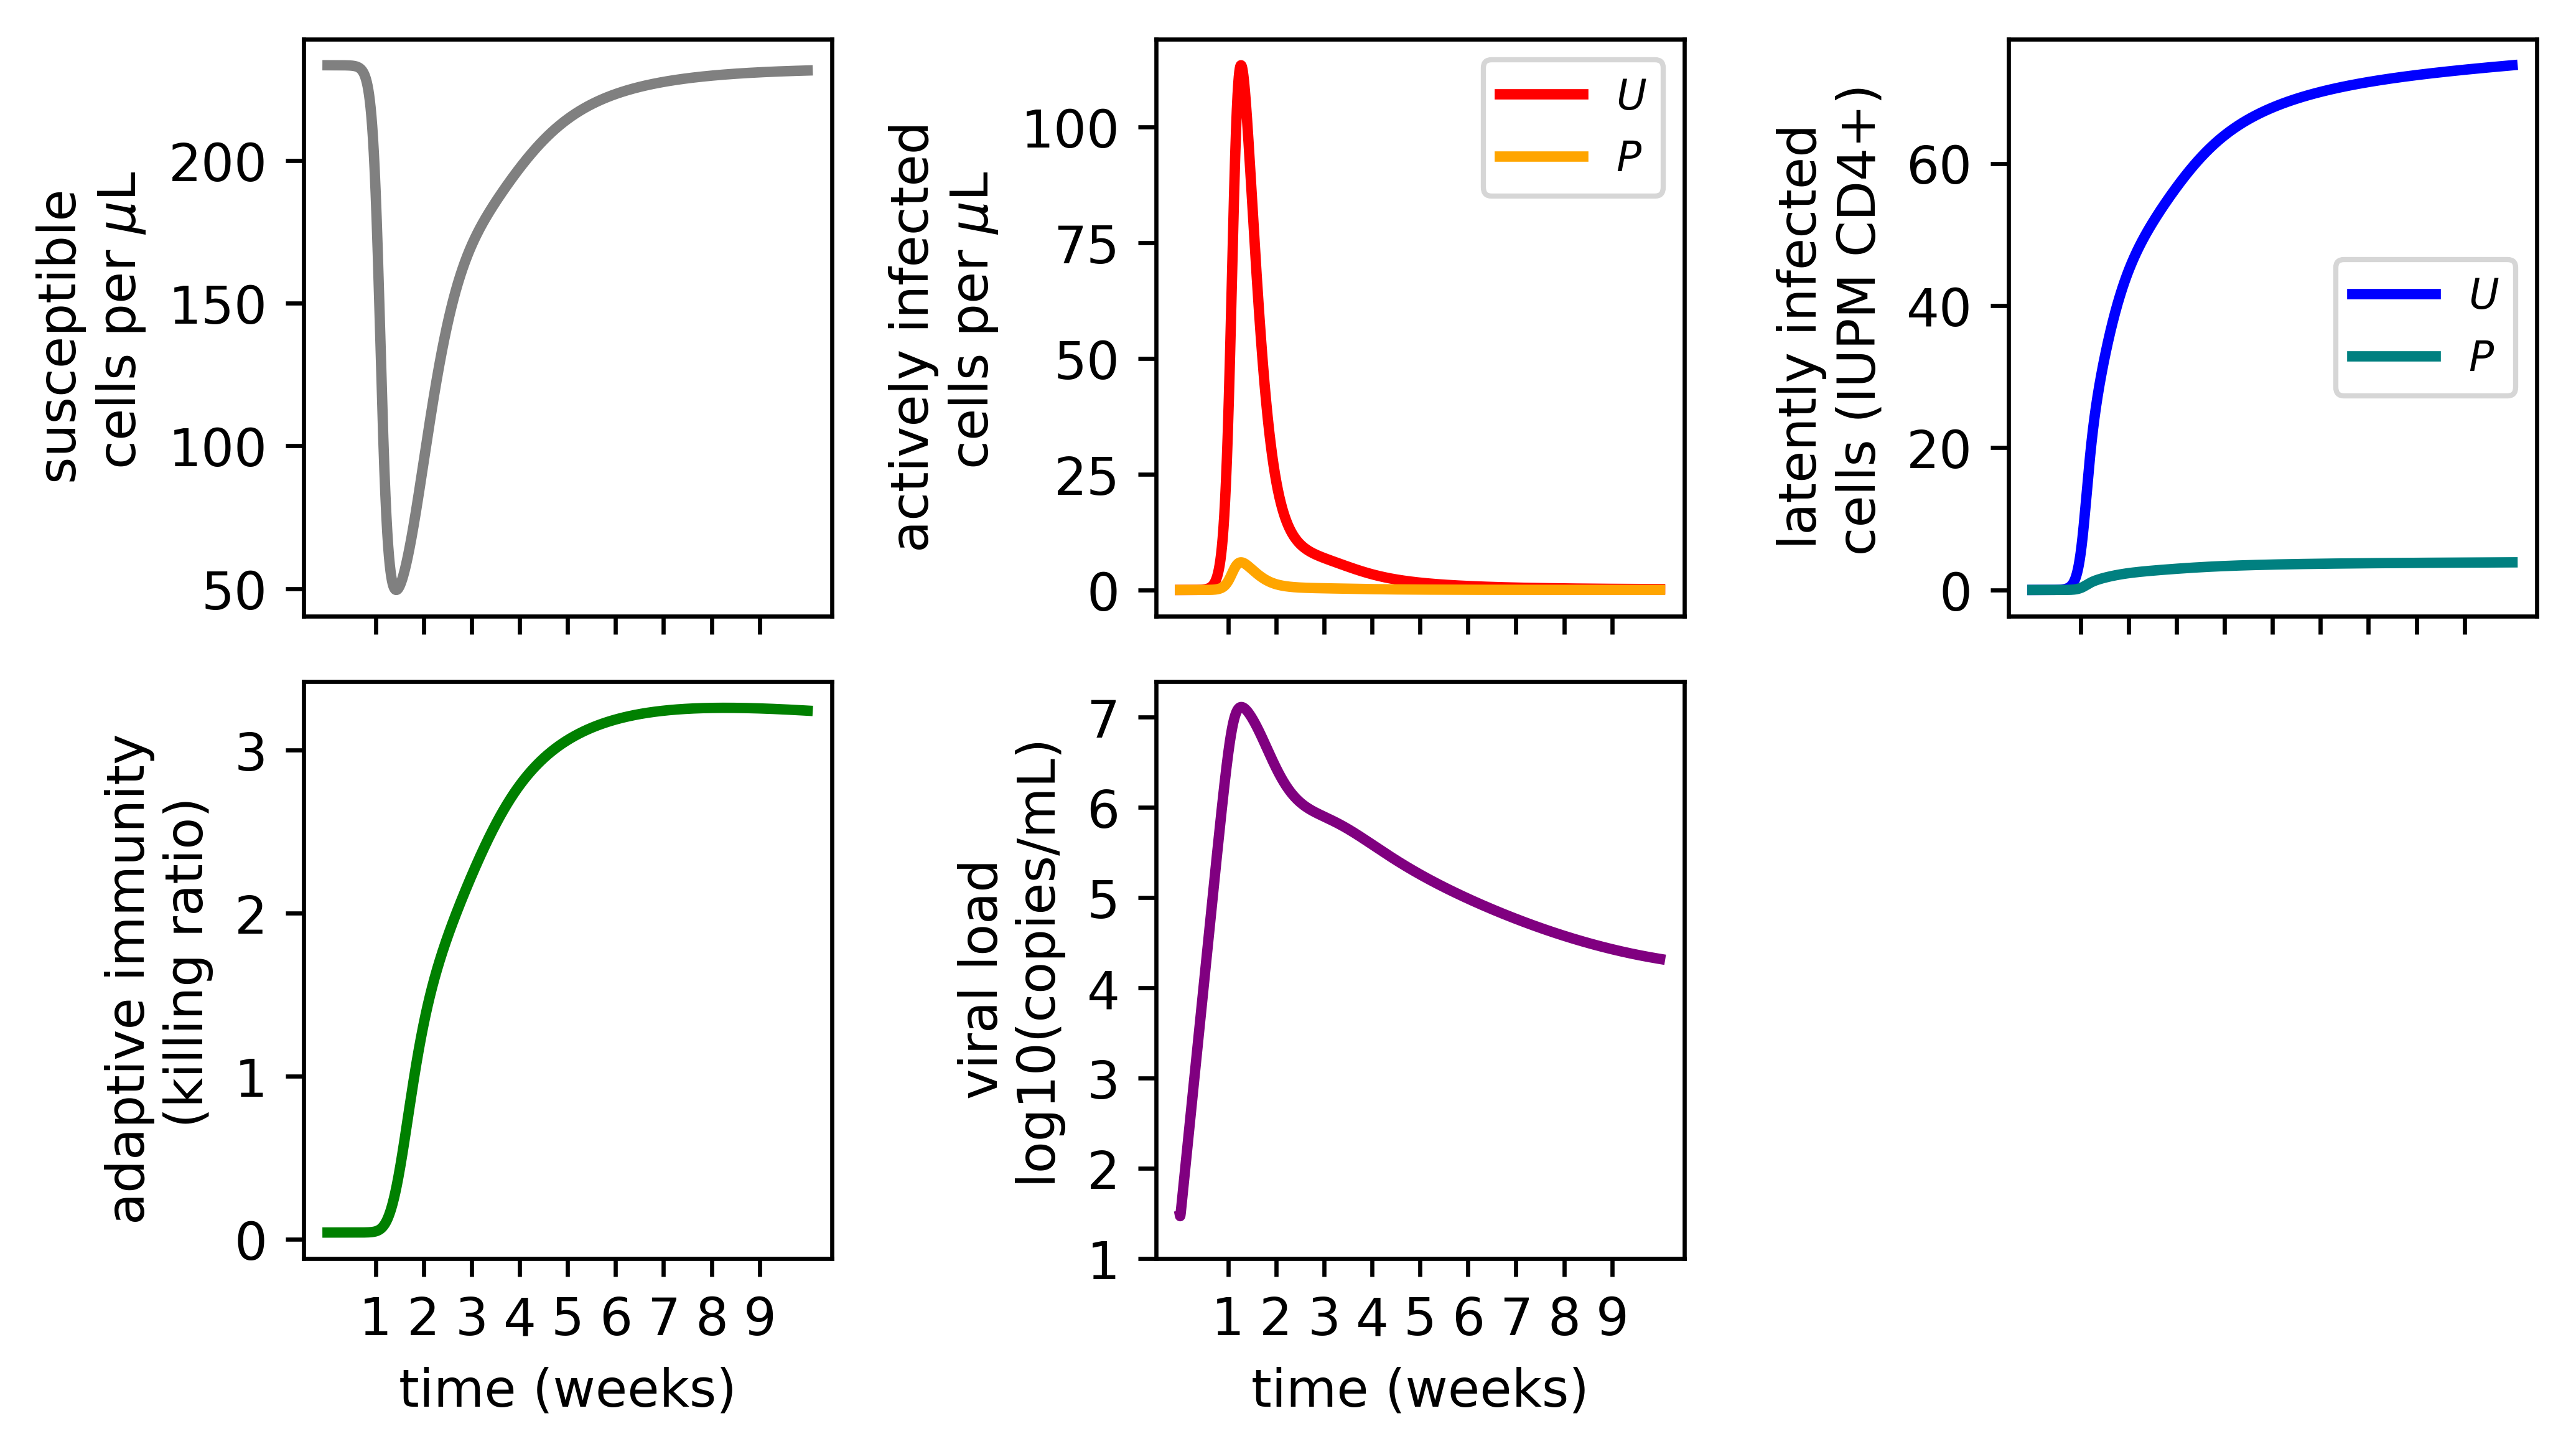

In [5]:
# parameters for viral dynamics model
aS  = 70;       # constant growth rate of susceptibles [cells/uL/day]
dS  = 0.3;      # susceptible death rate [1/day] 
Bt0 = 1e-4      # infection rate of T-cells [uL/cells-day]
dI  = 0.6       # infected cell death rate [1/day]
p   = 5e4       # burst rate of virus from cells [virions/cell]
g   = 23        # virus clearance rate [1/day]
tau = 0.05      # productive infection probability []
lam = 1e-4      # latency probability []
xi  = 1e-5;     # latent activation rate [1/day]
thL = 5.2e-4    # latent clearance rate [1/day]
k   = 0.5;      # immune cell killing rate [uL/cell-day]
w   = 1.6;       # immune cell multiplier [1/day]
aE  = 1e-4;     # immune cell addition [cells/uL-day]
dE  = 0.002;    # immune death rate [1/day]
E50 = 250;      # 50 pct max E cell concentration [cells/uL]*[uL]

R0=aS*Bt0*tau*(1-lam)*p/g/dS/dI; print('R0= ',R0) # basic reproductive number after first positive

S0=aS/dS; #assumes no real T cell depletion in very early infection
V0=0.03; #viral load at 30 copies/mL detection limit
I0=V0*g/p #assumes at equilibrium
AU0=tau*(1-lam)*I0; AP0=(1-tau)*(1-lam)*I0; LU0=tau*lam*I0; LP0=(1-tau)*lam*I0; #assumes proportions are ok
E0=aE/dE #assumes no real immune response before first positive?

X0=np.array([S0,AU0,AP0,LU0,LP0,E0,V0])

t=np.linspace(0,10*7,1e4) #25 weeks

sol,vll,infpoz,t_fp,t_max=run_model(t,X0,aS,dS,Bt0,tau,lam,dI,thL,xi,k,aE,dE,E50,w,p,g) 

plt.figure(figsize=(7,4),dpi=rez)
    
plt.subplot(231)
plt.plot(t/7,sol[:,0],'gray',lw=2)
plt.ylabel('susceptible \n cells per $\mu$L')

plt.subplot(232)
plt.plot(t/7,sol[:,1],'red',lw=2)
plt.plot(t/7,sol[:,2],'orange',lw=2)
plt.ylabel('actively infected \n cells per $\mu$L')
plt.legend(['$U$','$P$'],fontsize=8)

plt.subplot(233)
plt.plot(t/7,sol[:,3]*1000,'blue',lw=2) #divide by 1000 CD4+ T cells and then multiply by 1 million
plt.plot(t/7,sol[:,4]*1000,'teal',lw=2)
plt.ylabel('latently infected \n cells (IUPM CD4+)')
plt.legend(['$U$','$P$'],fontsize=8)

plt.subplot(234)
#plt.plot(t/7,sol[:,5]/E0,'green',lw=2)
#plt.ylabel('adaptive immunity \n (fold increase)')
te=0
It=sol[te:,1]+sol[te:,2]
Et=sol[te:,5]
plt.plot(t[te:]/7,Et*k/dI,'green',lw=2)
#plt.plot(t/7,Et*k/(It*dI+Et*k)*100,'green',lw=2)
plt.ylabel('adaptive immunity \n (killing ratio)')

plt.subplot(235)
plt.plot(t/7,vll,'purple',lw=2)
#axarr[4].axhline(np.log10(30),color='k')
#axarr[4].axvline(t_fp/7,ls='--',color='k',lw=0.5)
#axarr[4].annotate('detect lim',xy=[10,0],fontsize=8)
#axarr[4].annotate('$t_{+}=$'+str(round(t_fp,1))+'days',fontsize=8,xy=(t_fp/7, np.log10(30)), xytext=(3, -3),arrowprops=dict(color='black',width=1, headwidth=5,shrink=10))
plt.ylabel('viral load \n log10(copies/mL)')
plt.yticks(range(1,8,1))

for i in range(5):
    plt.subplot(231+i)
    if i>2:
        plt.xlabel('time (weeks)')
        plt.xticks(range(1,10,1))
    else:
        plt.xticks(range(1,10,1),[])
        
plt.tight_layout()
plt.savefig('figures/det_model.pdf')


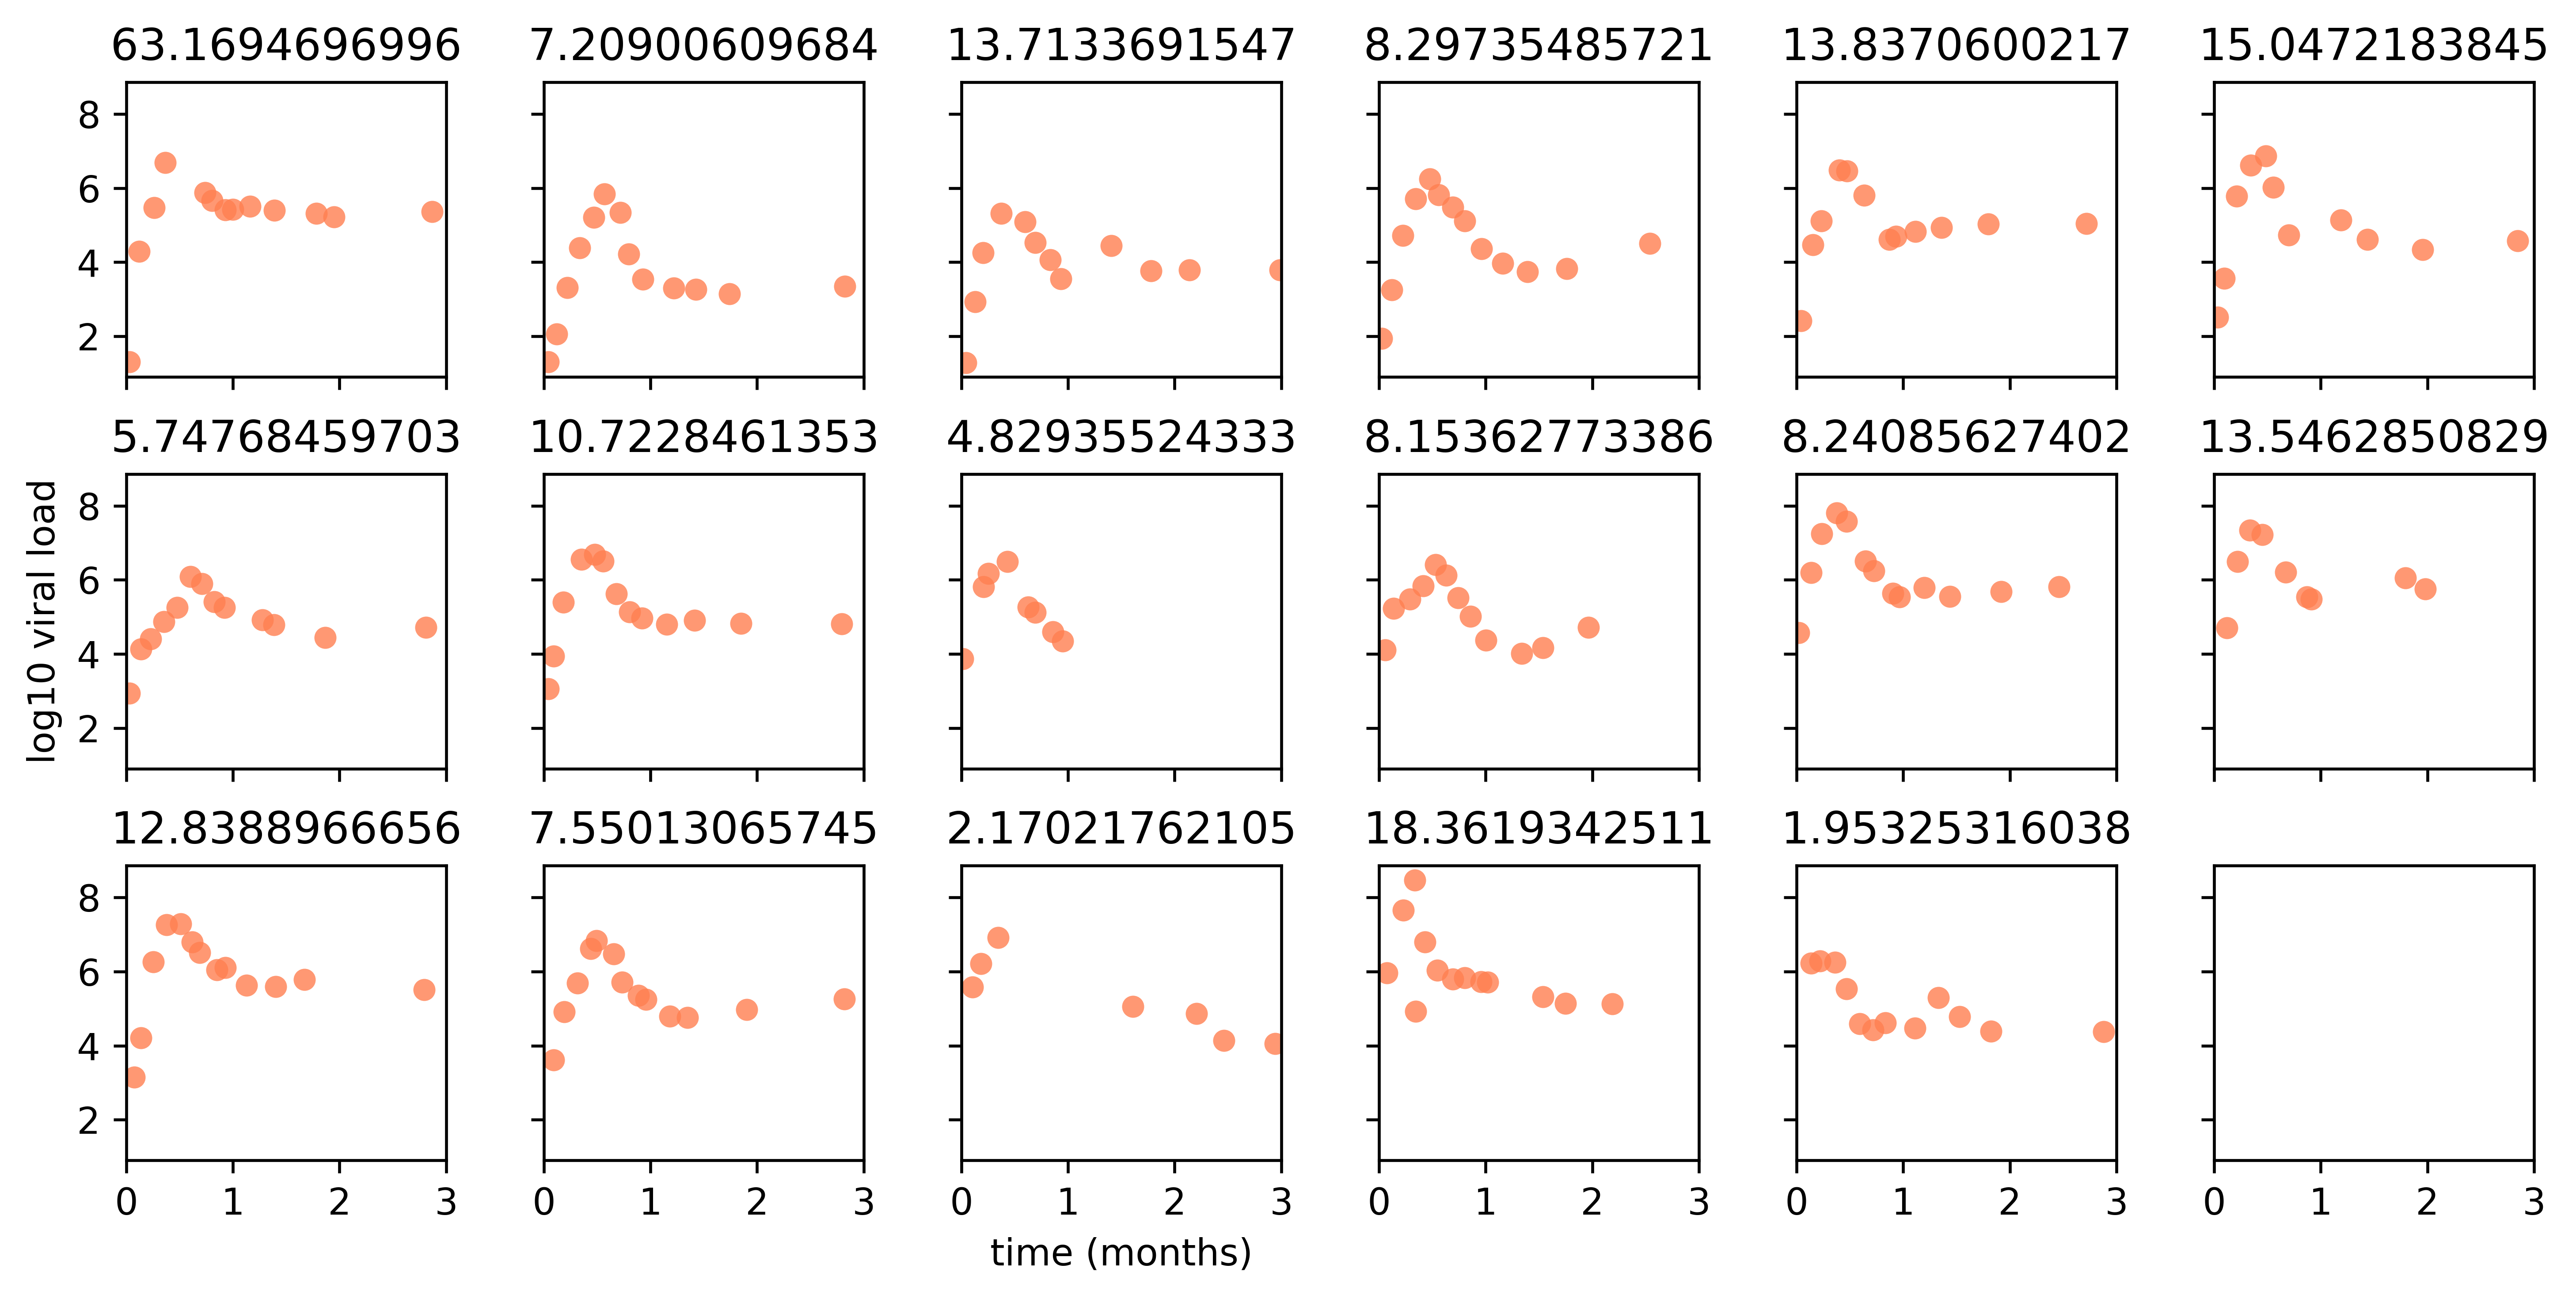

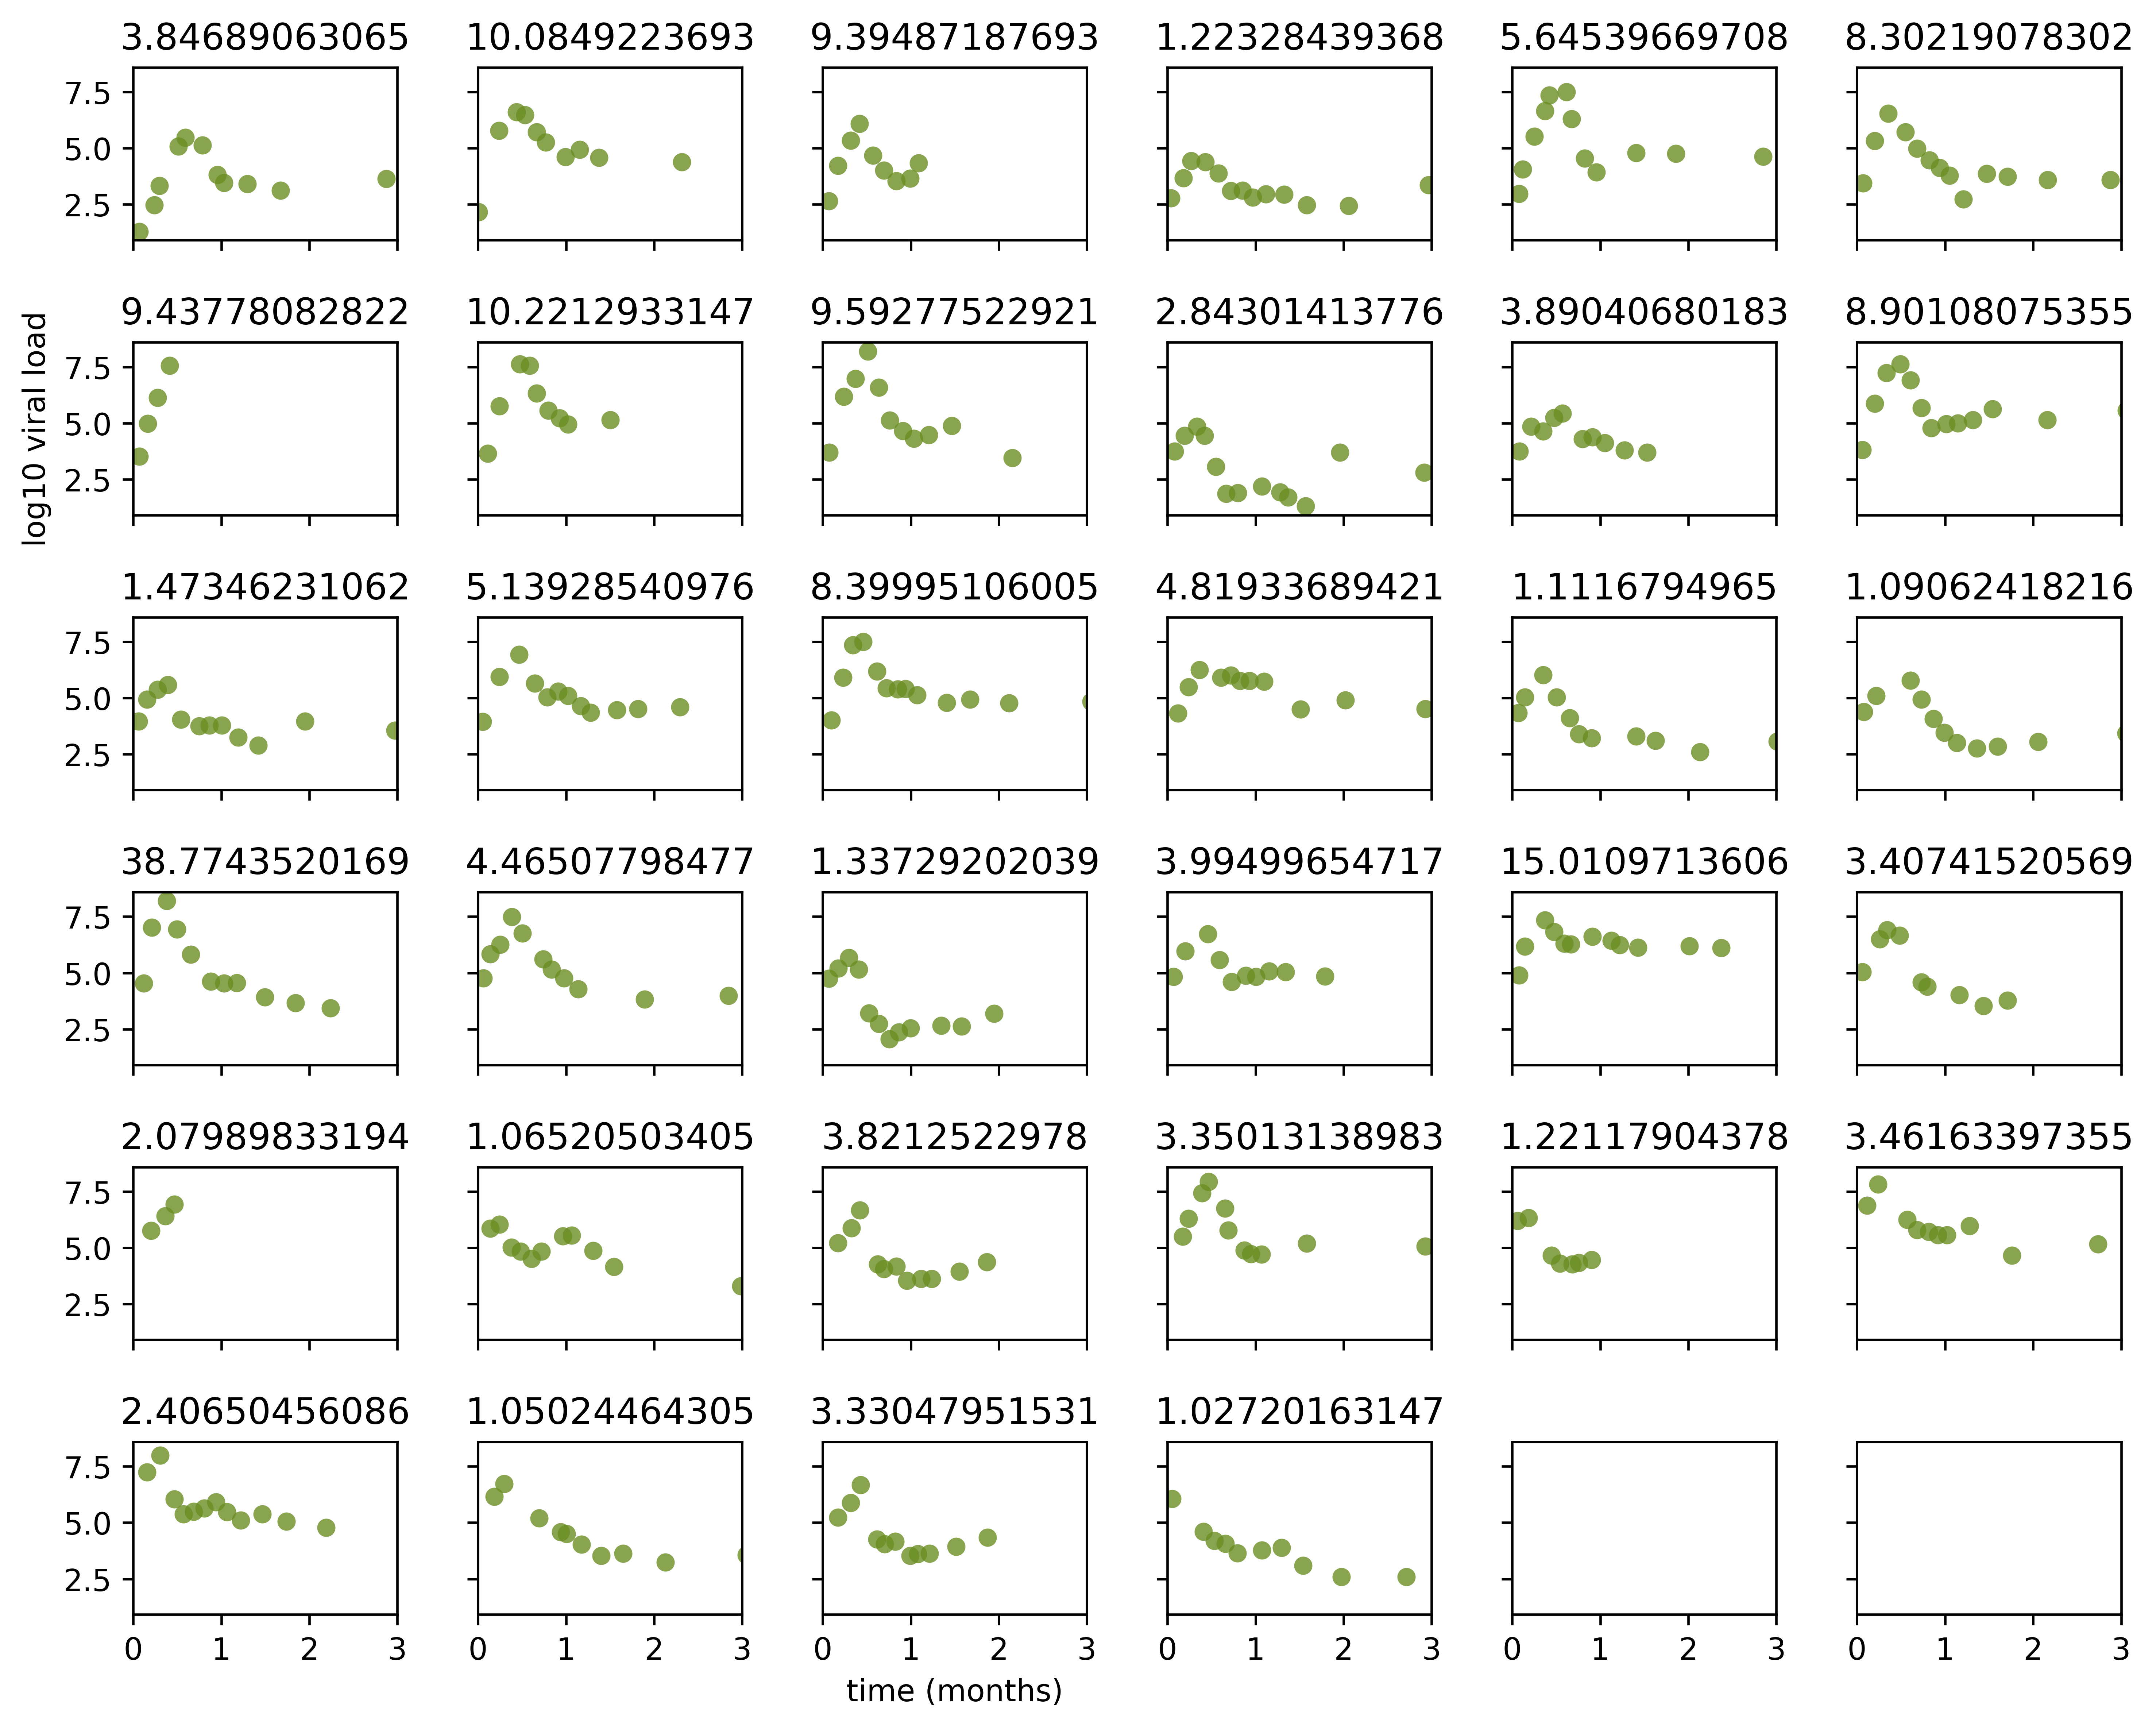

In [6]:
#calulate max R0
def calc_R0(t_data,V_data):
    inmx=np.argmax(np.diff(V_data[~np.isnan(V_data)]))
    dV=10**V_data[inmx+1]/10**V_data[inmx]
    dt=(t_data[inmx+1]-t_data[inmx])*30 #put it back in days
    r=np.log(dV)/dt
    R0=(r/dI+1)*np.exp(r)
    return R0

R0_list=[[],[]]
thai=pd.read_csv('data/robb-scrape/wpd_thai.csv')
africa=pd.read_csv('data/robb-scrape/wpd_africa.csv')

N_thai=int(len(thai.columns)/2)
fig,axarr=plt.subplots(3,6,sharey=True,sharex=True,figsize=(10,5),dpi=rez)

for i in range(N_thai):
    x=np.array(pd.to_numeric(thai.iloc[1:,2*i])/30)
    y=np.array(pd.to_numeric(thai.iloc[1:,2*i+1]))
    indz=np.argsort(x) #make sure time is in order
    t_data=x[indz]; V_data=y[indz]
    ax=axarr[int(i/6)][i%6]
    ax.scatter(t_data,V_data,c='coral',marker='o',lw=0,alpha=0.8)
    #axarr[int(i/4)][i%4].legend({YES.columns[2*i]})
    
    R0=calc_R0(t_data,V_data)
    R0_list[0].append(R0)
    ax.set_title(R0)
    
plt.xlim([0,3])
plt.xticks(range(4))
axarr[2][2].set_xlabel('time (months)')
axarr[1][0].set_ylabel('log10 viral load')
plt.tight_layout()

N_africa=int(len(africa.columns)/2)
fig,axarr=plt.subplots(6,6,sharey=True,sharex=True,figsize=(10,8),dpi=rez)

for i in range(N_africa):
    x=np.array(pd.to_numeric(africa.iloc[1:,2*i])/30)
    y=np.array(pd.to_numeric(africa.iloc[1:,2*i+1]))
    indz=np.argsort(x) #make sure time is in order
    t_data=x[indz]; V_data=y[indz]
    ax=axarr[int(i/6)][i%6]
    ax.scatter(t_data,V_data,c='olivedrab',marker='o',lw=0,alpha=0.8)

    R0=calc_R0(t_data,V_data)
    R0_list[1].append(R0)
    ax.set_title(R0)

plt.xlim([0,3])
plt.xticks(range(4))
axarr[5][2].set_xlabel('time (months)')
axarr[1][0].set_ylabel('log10 viral load')
plt.tight_layout()

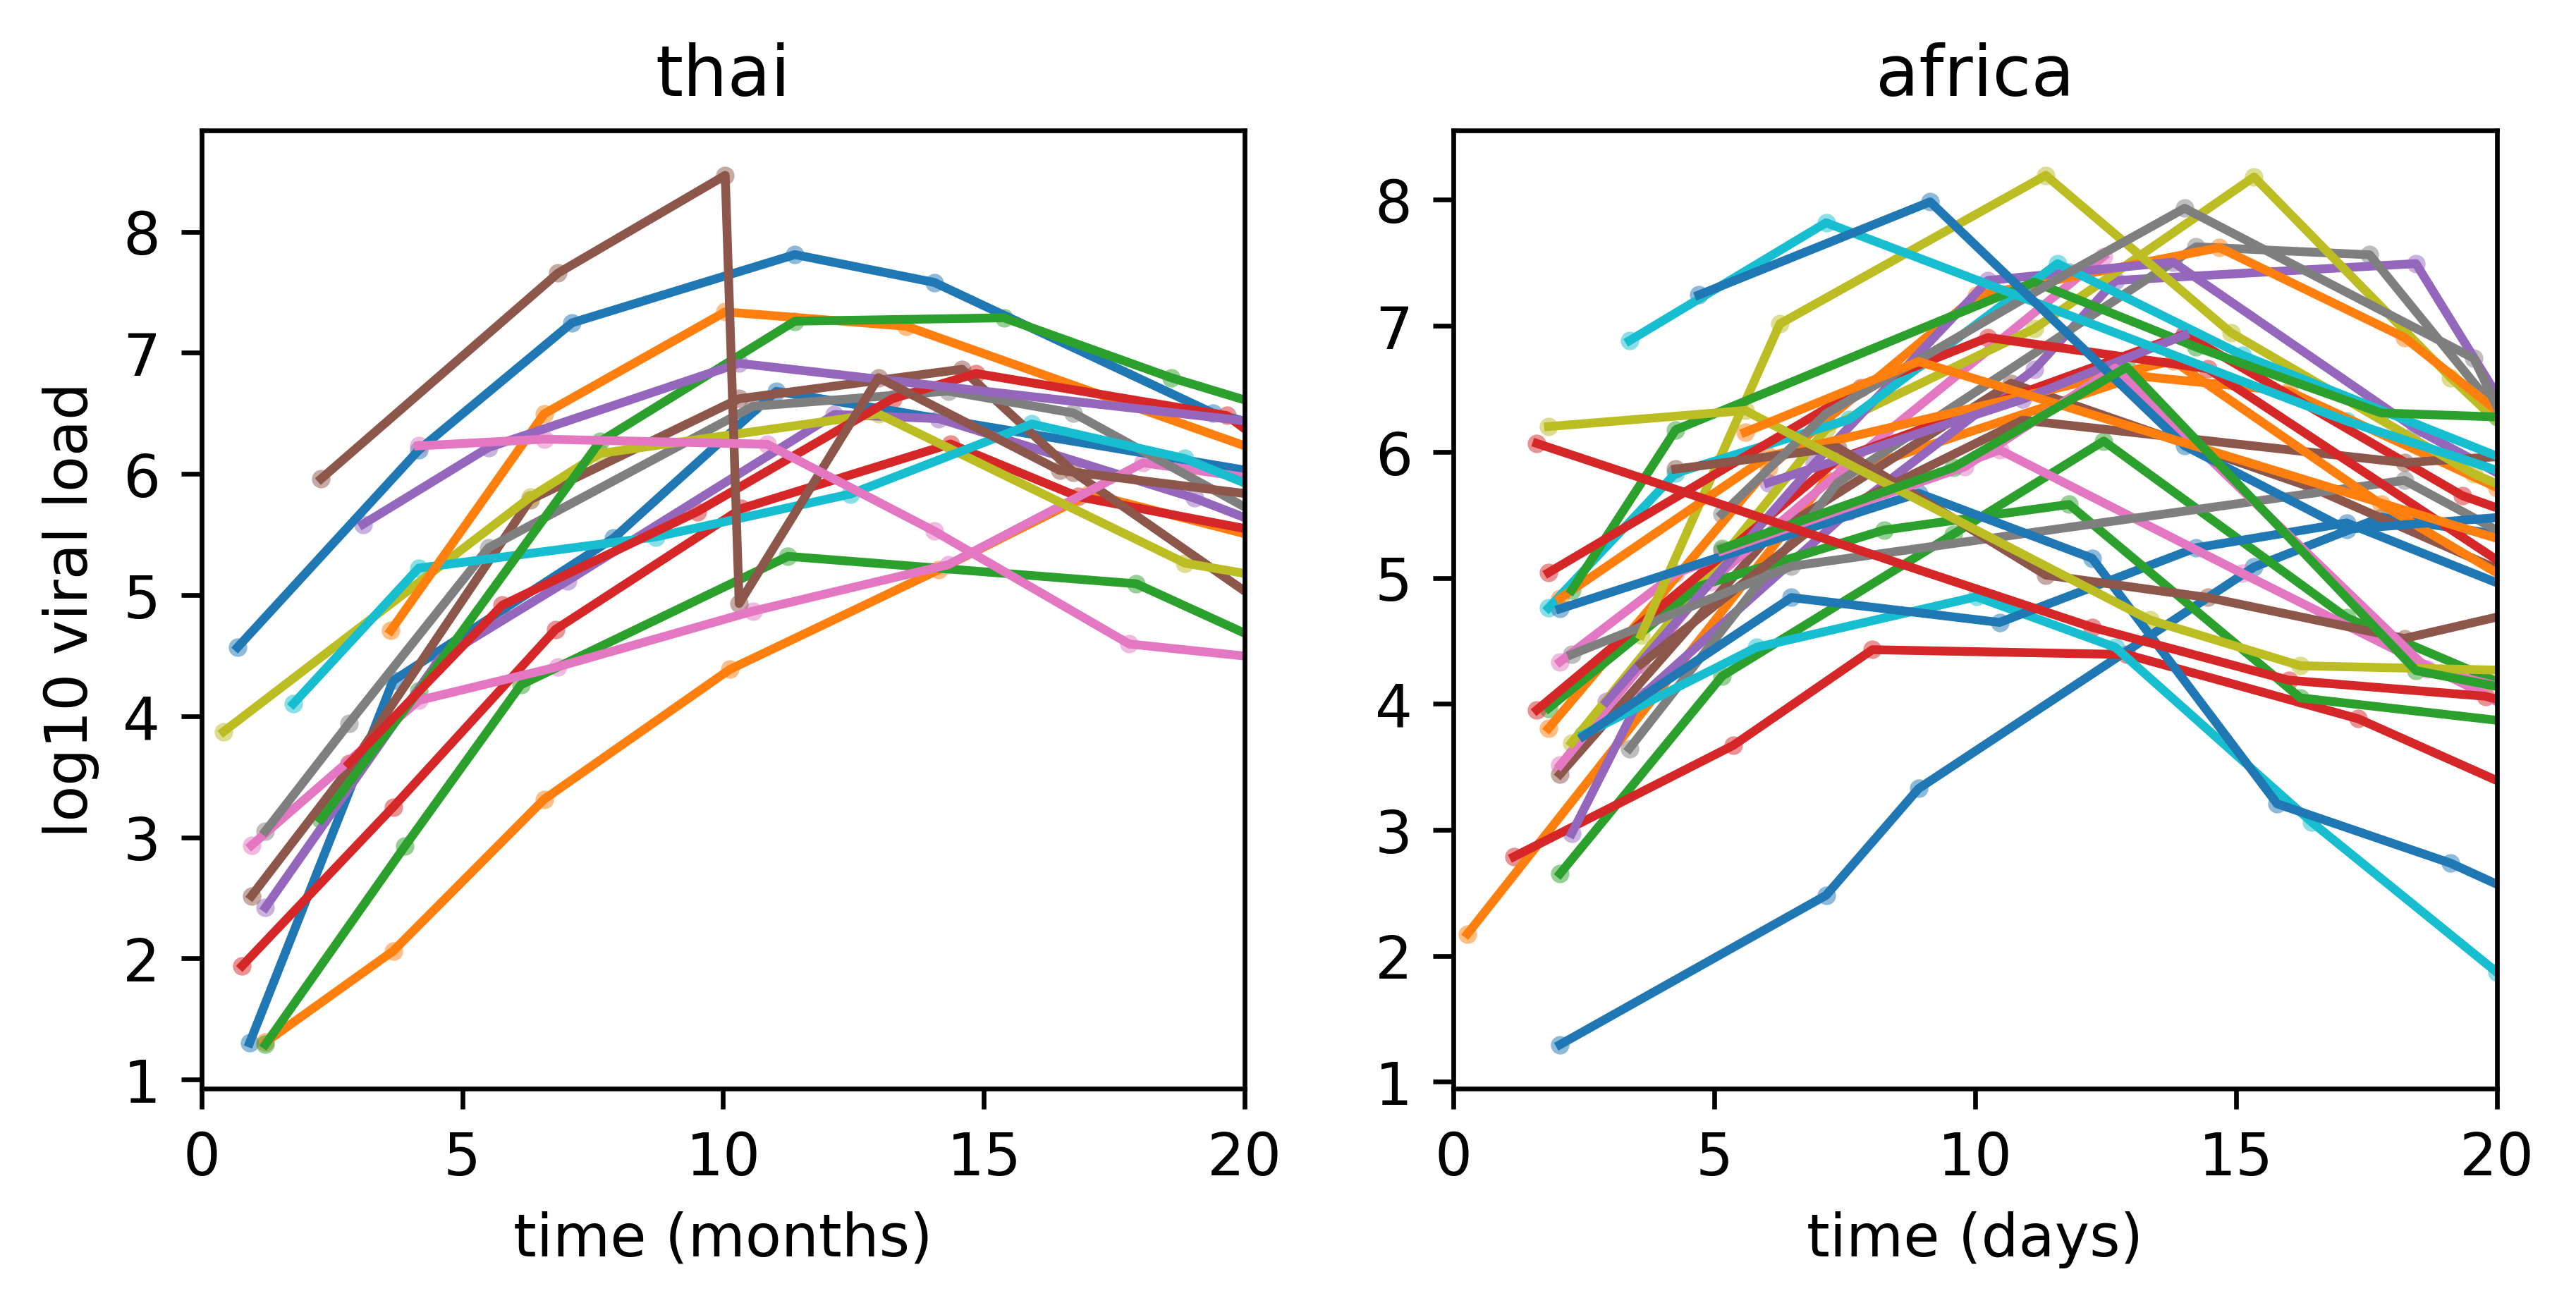

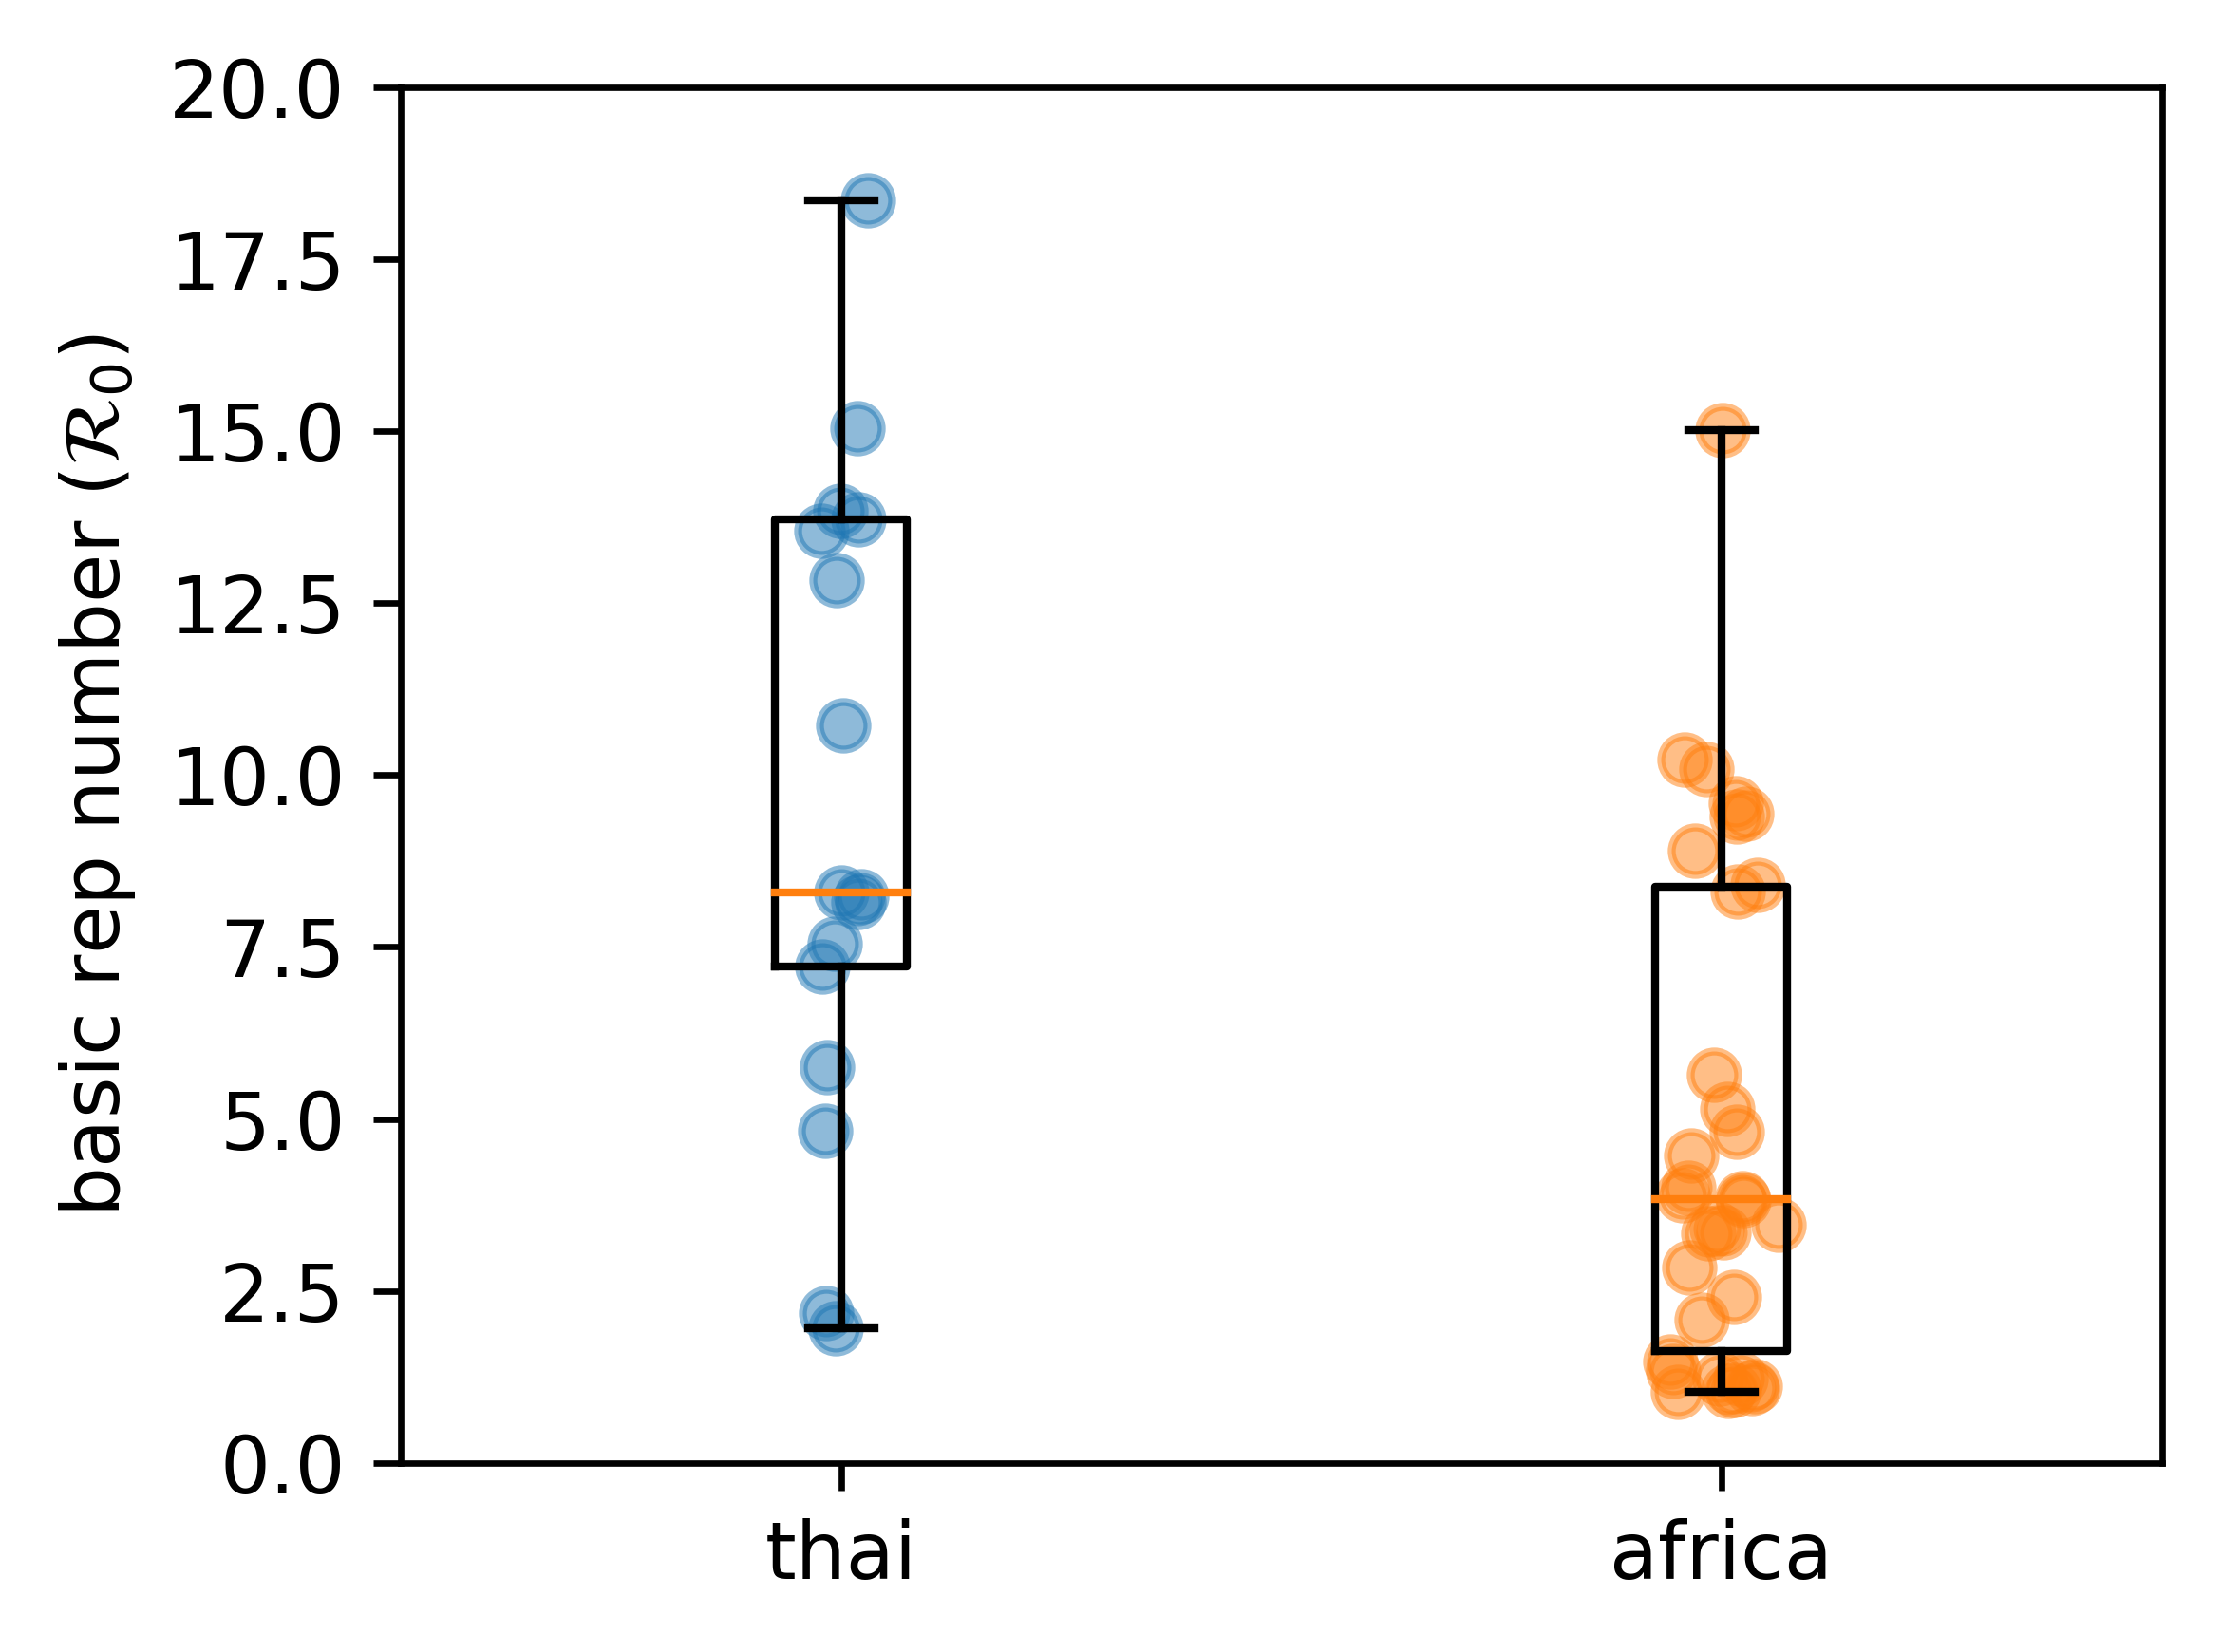

In [5]:
#plot all early curves and compare R0
plt.figure(figsize=(7,3),dpi=rez)

plt.subplot(121)
for i in range(N_thai):
    x=np.array(pd.to_numeric(thai.iloc[1:,2*i]))
    y=np.array(pd.to_numeric(thai.iloc[1:,2*i+1]))
    indz=np.argsort(x) #make sure time is in order
    t_data=x[indz]; V_data=y[indz]
    plt.plot(t_data,V_data)
    plt.scatter(t_data,V_data,lw=0,s=10,alpha=0.5)    
plt.ylabel('log10 viral load')
plt.xlim([0,20])
plt.title('thai')
plt.xlabel('time (months)')

plt.subplot(122)
for i in range(N_africa):
    x=np.array(pd.to_numeric(africa.iloc[1:,2*i]))
    y=np.array(pd.to_numeric(africa.iloc[1:,2*i+1]))
    indz=np.argsort(x) #make sure time is in order
    t_data=x[indz]; V_data=y[indz]
    plt.plot(t_data,V_data)
    plt.scatter(t_data,V_data,lw=0,s=10,alpha=0.5)
plt.title('africa')
plt.xlim([0,20])
plt.xlabel('time (days)')

plt.figure(figsize=(4,3),dpi=rez)
plt.boxplot(R0_list)
plt.xticks([1,2],['thai','africa'])
plt.ylabel(r'basic rep number ($\mathcal{R}_0$)')
plt.xlim([0.5,2.5])
plt.ylim([0,20])
for i in range(2):
    plt.scatter(np.random.normal(1,0.02,len(R0_list[i]))*(i+1),R0_list[i],alpha=0.5)

plt.tight_layout()
fig.savefig('figures/myrobb_data.pdf')


(array([  9.,  11.,   4.,   0.,   6.,   2.,   0.,   1.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   1.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.]),
 array([ 0,  2,  4,  6,  8, 10, 12, 14, 16, 18, 20, 22, 24, 26, 28, 30, 32,
        34, 36, 38, 40, 42, 44, 46, 48, 50, 52, 54, 56, 58, 60, 62, 64, 66,
        68, 70, 72, 74, 76, 78, 80, 82, 84, 86, 88, 90, 92, 94, 96, 98]),
 <a list of 49 Patch objects>)

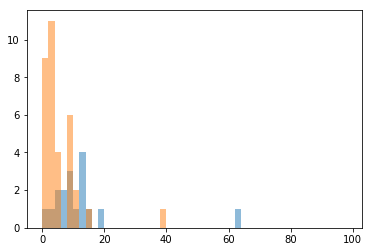

In [6]:
#compare R0 via histograms
plt.hist(R0_list[0],np.arange(0,100,2),alpha=0.5)
plt.hist(R0_list[1],np.arange(0,100,2),alpha=0.5)

In [7]:
#cumulative probability

(0, 30)

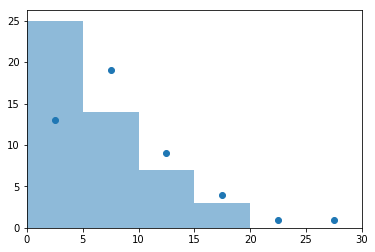

In [8]:
plt.hist(sum(R0_list,[]),np.arange(0,100,5),alpha=0.5)

plt.scatter(np.arange(0,30,5)+2.5,[13,19,9,4,1,1]) #ribeiro histogram
plt.xlim([0,30])

In [9]:
#function to make arrays for boundaries
def make_bounds(guess,fac):
    bounds=tuple([tuple(np.array(guess)/fac),tuple(np.array(guess)*fac)])
    return bounds

In [10]:
# MODEL 1

#parametesr to fit
dS  = 0.2;   #susceptible death rate [1/day] 
tau = 0.05      # productive infection probability []
k   = 0.3;  #immune cell killing rate [uL/cell-day]/[uL]
w   = 1.6;     #immune cell multiplier [1/day]
dE  = 0.002;  #immune death rate [1/day]
E50 = 250;   #50 pct max E cell concentration [cells/uL]*[uL]

guess=dS,tau,k,dE,E50,w

N=N_thai+N_africa
po_arr=np.zeros([len(guess),N]); pc_arr=np.zeros([len(guess),len(guess),N]); #intialize arrays

#loop through all and fit
indN=0; goodN=[];
while indN<N:
    
    if indN<N_thai:
        x=np.array(pd.to_numeric(thai.iloc[1:,2*indN].dropna())) #keep in days
        y=np.array(pd.to_numeric(thai.iloc[1:,2*indN+1]))
    else:
        x=np.array(pd.to_numeric(africa.iloc[1:,2*(indN-N_thai)].dropna())) #keep in days
        y=np.array(pd.to_numeric(africa.iloc[1:,2*(indN-N_thai)+1]))    
    
    indz=np.argsort(x) #make sure time is in order

    #only fit those with data beyond 4 weeks and more than 5 data points
    if max(x/7)<4 or len(indz)<5:
        indN+=1        
    else:
        t_data=x[indz]; V_data=y[indz]

        #V_data = np.log10(prim_df.iloc[:,m].interpolate(method='linear',axis=0,limit=2)) #use log data

        #makes model to be fit
        def fit_model(tt,dS,tau,k,dE,E50,w):  

            #peg some parameters
            aS  = 70;   #constant growth rate of susceptibles [cells/uL/day]
            Bt0 = 1e-4  # infection rate of T-cells [uL/cells-day]/[uL]
            dI  = 1.0       # active death rate [1/day]
            p   = 5e4       # burst rate of virus from cells [virions/cell]
            g   = 23        # virus clearance rate [1/day]
            lam = 1e-4      # latency probability []
            thL = 5.2e-4    # latent clearance rate [1/day]
            xi  = 1e-5;     # latent activation rate [1/day]
            aE  = 1e-4;   #initial E cell concentration [cells/uL]*[uL]

            #compute equilibria for these
            S0=aS/dS
            E0=aE/dE

            V0=np.log10(V_data[0]) #assume starts at V_data from the actual data

            #calculate the rest of initial conditions
            AU0=g/p*V0*(1-tau)
            AP0=g/p*V0*tau
            LU0=g/p*V0*(1-tau)*lam
            LP0=g/p*V0*tau*lam

            X0=np.array([S0,AU0,AP0,LU0,LP0,E0,V0]) #start with a single infected cell
            sol=spi.odeint(det_model, X0, tt, (aS,dS,Bt0,tau,lam,dI,thL,xi,k,aE,dE,E50,w,p,g), mxstep=10000) #solve model
            vll=np.log10(sol[:,6]*1e3) #viral load as usual units copies/mL
            return vll

        #model fit
        po, pc = curve_fit(fit_model, t_data, V_data, p0=guess, bounds=make_bounds(guess,1000),sigma=0.1,absolute_sigma=False,
                            max_nfev=1e3, verbose=1, xtol=1e-15, ftol=1e-15, gtol=1e-15)

        dS,tau,k,dE,E50,w=po

        po_arr[:,indN]=po
        #pc_arr[:,:,i]=pc

        goodN.append(indN)
        indN+=1


`xtol` termination condition is satisfied.
Function evaluations 27, initial cost 3.0736e+02, final cost 1.6961e+02, first-order optimality 3.04e+02.
`xtol` termination condition is satisfied.
Function evaluations 48, initial cost 2.5140e+03, final cost 1.0542e+02, first-order optimality 4.65e+02.


/Applications/anaconda/lib/python3.6/site-packages/ipykernel/__main__.py:65: RuntimeWarning: invalid value encountered in log10


`xtol` termination condition is satisfied.
Function evaluations 61, initial cost 1.3294e+03, final cost 9.2171e+01, first-order optimality 1.05e+02.
`xtol` termination condition is satisfied.
Function evaluations 34, initial cost 1.0398e+03, final cost 6.6979e+01, first-order optimality 6.57e+02.
`xtol` termination condition is satisfied.
Function evaluations 36, initial cost 4.8560e+02, final cost 5.7448e+01, first-order optimality 3.90e+03.
`xtol` termination condition is satisfied.
Function evaluations 31, initial cost 3.0541e+02, final cost 9.4568e+01, first-order optimality 3.19e+02.
`xtol` termination condition is satisfied.
Function evaluations 46, initial cost 7.8356e+02, final cost 1.8118e+02, first-order optimality 1.70e+04.
`xtol` termination condition is satisfied.
Function evaluations 39, initial cost 2.2885e+02, final cost 6.5814e+01, first-order optimality 2.43e+02.
`xtol` termination condition is satisfied.
Function evaluations 34, initial cost 5.1368e+02, final cost 9.

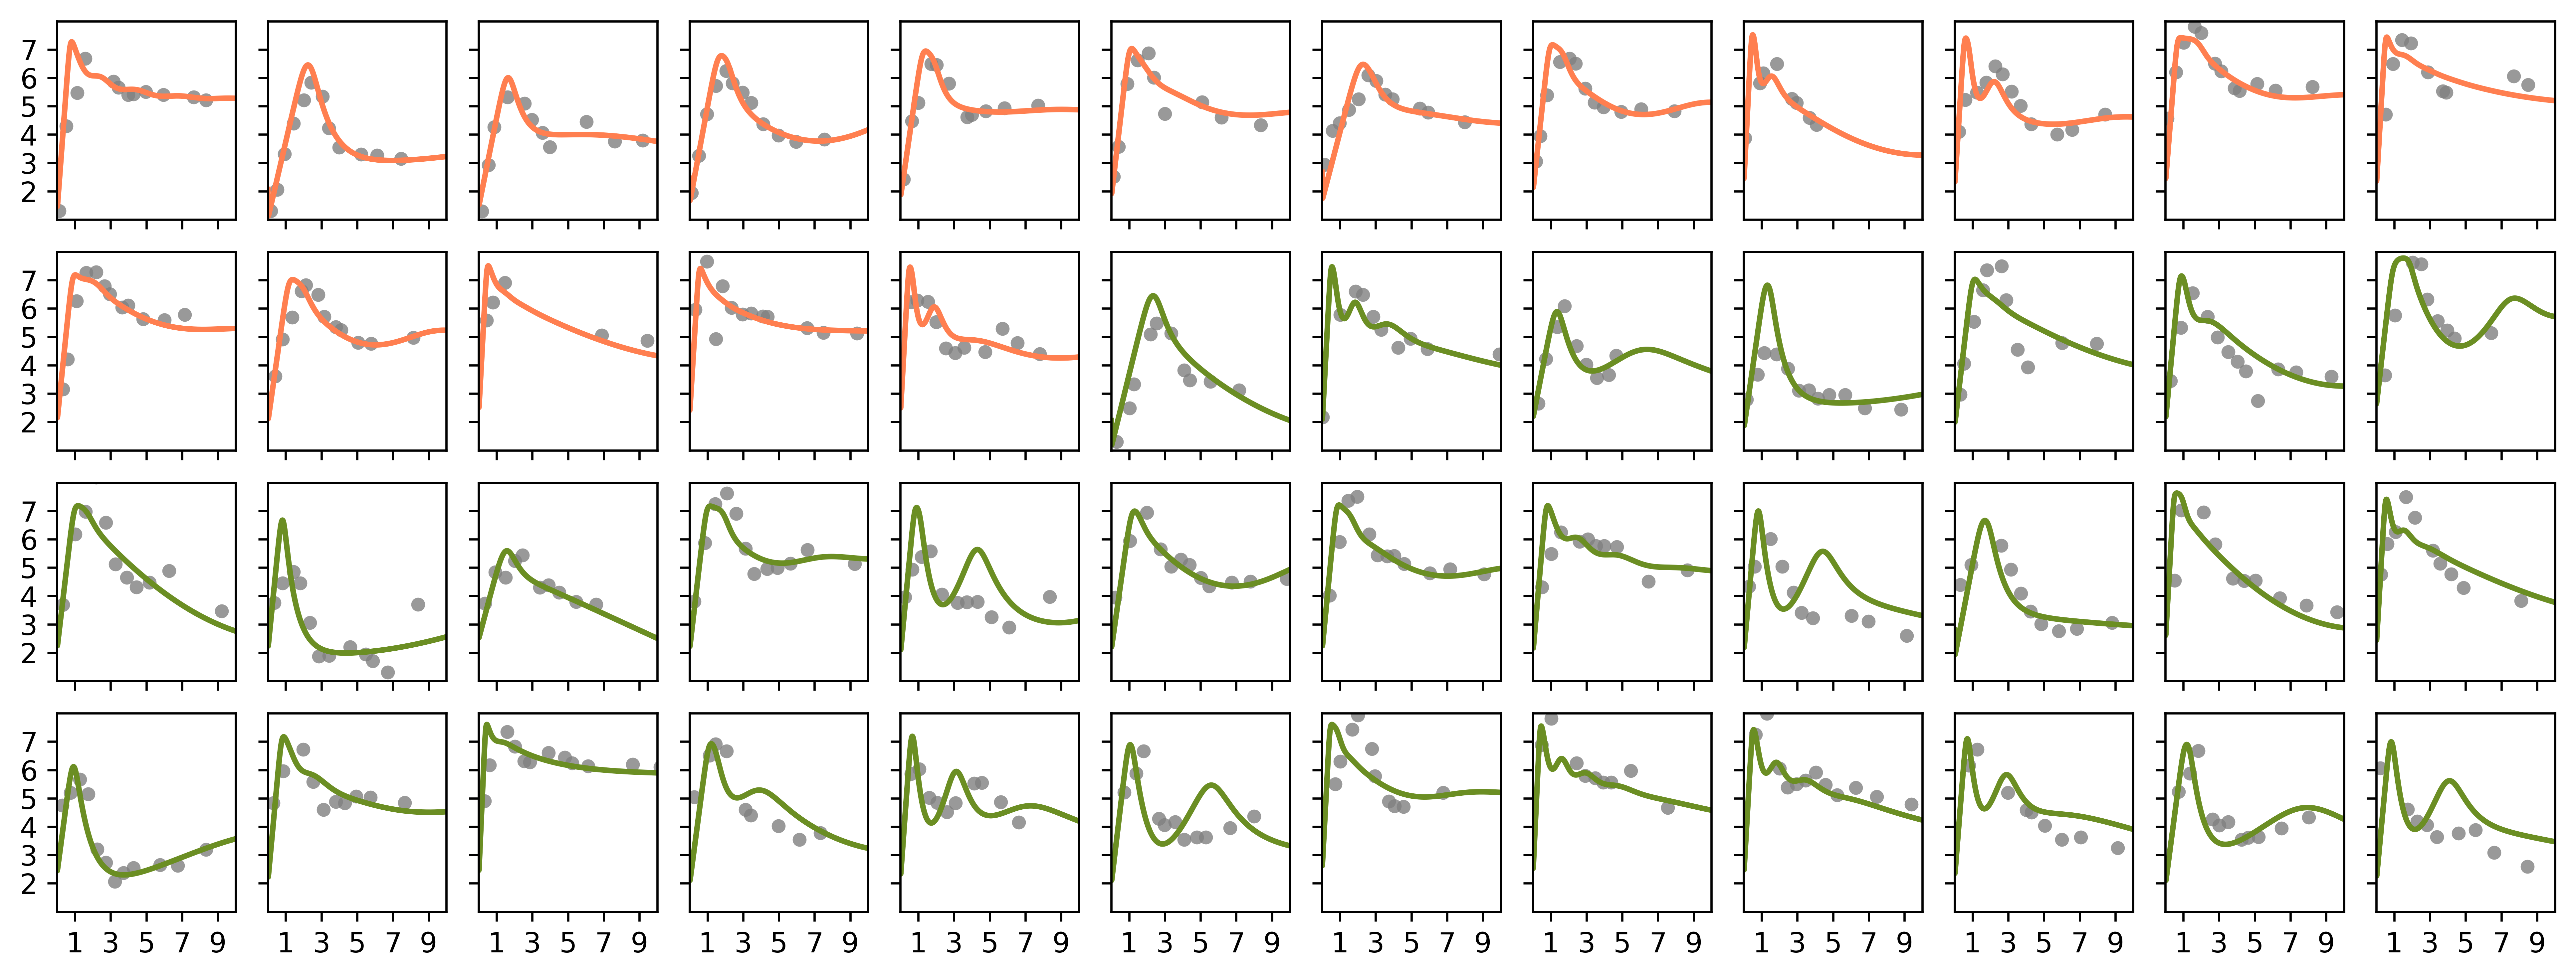

In [11]:
#plot MODEL 1
nx=12; ny=4;
fig,axarr=plt.subplots(ny,nx,sharey=True,sharex=True,figsize=(13,5),dpi=rez)

t_sim=np.linspace(0,400,1e4);

#loop through good data sets
for i in range(len(goodN)):    
    indN=goodN[i]
    if indN<N_thai:
        x=np.array(pd.to_numeric(thai.iloc[1:,2*indN].dropna())) #keep in days
        y=np.array(pd.to_numeric(thai.iloc[1:,2*indN+1]))
        col='coral'
    else:
        x=np.array(pd.to_numeric(africa.iloc[1:,2*(indN-N_thai)].dropna())) #keep in days
        y=np.array(pd.to_numeric(africa.iloc[1:,2*(indN-N_thai)+1]))    
        col='olivedrab'
    
    indz=np.argsort(x) #make sure time is in order
    t_data=x[indz]; V_data=y[indz]

    #makes model to be fit
    def fit_model(tt,dS,tau,k,dE,E50,w):  

        #peg some parameters
        aS  = 70;   #constant growth rate of susceptibles [cells/uL/day]
        Bt0 = 1e-4  # infection rate of T-cells [uL/cells-day]/[uL]
        dI  = 1.0       # active death rate [1/day]
        p   = 5e4       # burst rate of virus from cells [virions/cell]
        g   = 23        # virus clearance rate [1/day]
        lam = 1e-4      # latency probability []
        thL = 5.2e-4    # latent clearance rate [1/day]
        xi  = 1e-5;     # latent activation rate [1/day]
        aE  = 1e-4;   #initial E cell concentration [cells/uL]*[uL]

        #compute equilibria for these
        S0=aS/dS
        E0=aE/dE

        V0=np.log10(V_data[0]) #assume starts at V_data from the actual data

        #calculate the rest of initial conditions
        AU0=g/p*V0*(1-tau)
        AP0=g/p*V0*tau
        LU0=g/p*V0*(1-tau)*lam
        LP0=g/p*V0*tau*lam

        X0=np.array([S0,AU0,AP0,LU0,LP0,E0,V0]) #start with a single infected cell
        sol=spi.odeint(det_model, X0, tt, (aS,dS,Bt0,tau,lam,dI,thL,xi,k,aE,dE,E50,w,p,g), mxstep=10000) #solve model
        vll=np.log10(sol[:,6]*1e3) #viral load as usual units copies/mL
        return vll

    dS,tau,k,dE,E50,w=po_arr[:,indN]

    V_sim=fit_model(t_sim,dS,tau,k,dE,E50,w)

    axarr[int(i/nx)][i%nx].scatter(t_data/7,V_data,c='gray',marker='o',lw=0,s=25,alpha=0.8)
    axarr[int(i/nx)][i%nx].plot(t_sim/7,V_sim,lw=2,color=col)

plt.xlim([0,10])
plt.xticks(range(1,10,2))
plt.ylim([1,8])
plt.yticks(range(2,8))
plt.tight_layout()
plt.savefig('figures/myrobb_fits.pdf')


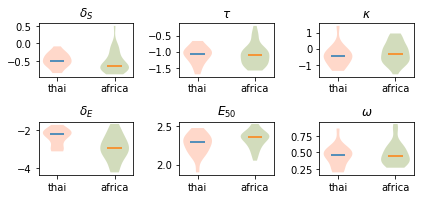

In [12]:
#make violin plots of best fit params
pz=[r'$\delta_S$',r'$\tau$',r'$\kappa$',r'$\delta_E$',r'$E_{50}$',r'$\omega$']

for i in range(len(pz)):
    plt.subplot(331+i)
    thaip=po_arr[i,:N_thai]
    africap=po_arr[i,N_thai:]
    
    thaip=np.log10(thaip[thaip!=0])
    africap=np.log10(africap[africap!=0])
    
    violzT=plt.violinplot([thaip],positions=[1],showextrema=False,showmedians=True)
    violzA=plt.violinplot([africap],positions=[2],showextrema=False,showmedians=True)

    for pc in violzT['bodies']:
        pc.set_facecolor('coral')
        #pc['cmedians'].set_edgecolor('k')
    for pc in violzA['bodies']:
        pc.set_facecolor('olivedrab')

    #plt.yscale('log')
    plt.title(pz[i])
    plt.xticks([1,2],['thai','africa'])
plt.tight_layout()
plt.savefig('figures/myrobb_violins.pdf')


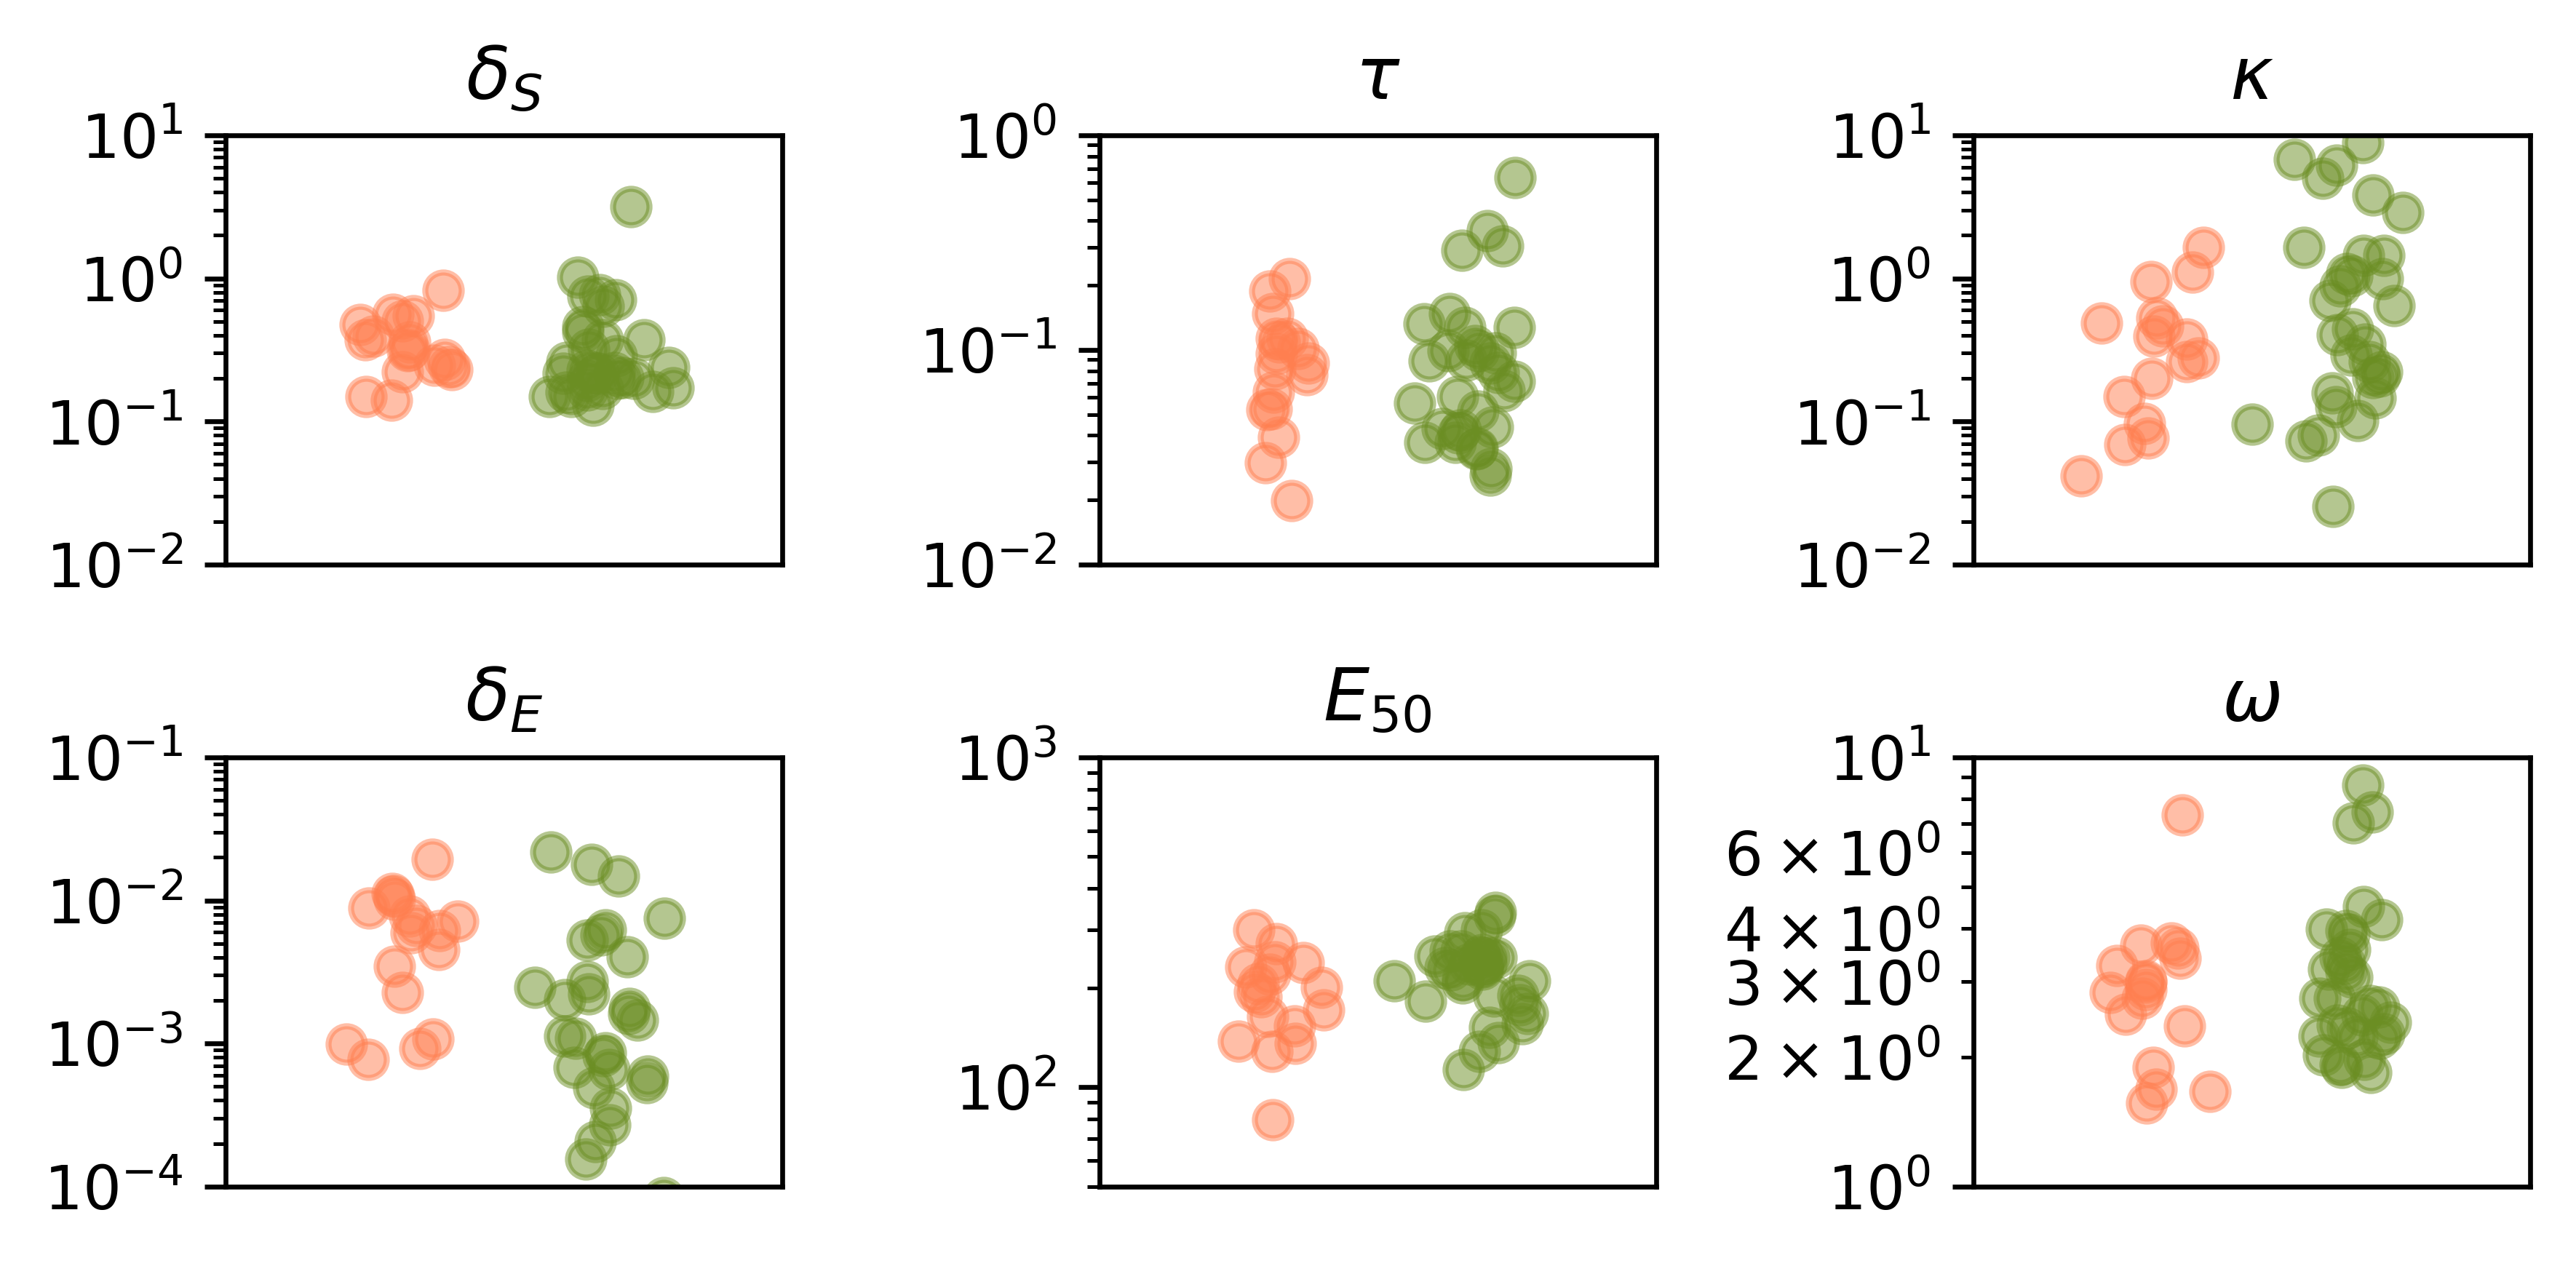

In [13]:
#make scatter plots instead

plt.figure(figsize=(6,3),dpi=rez)
thaipm=[]
africapm=[]

ylimz=[[1e-2,10],[1e-2,1],[1e-2,10],[1e-4,0.1],[50,1e3],[1,10]]
for i in range(len(pz)):
    plt.subplot(231+i)
    thaip=po_arr[i,:N_thai]
    africap=po_arr[i,N_thai:]

    thaip=thaip[thaip!=0]
    africap=africap[africap!=0]
    
    thaipm.append(np.mean(thaip))
    africapm.append(np.mean(africap))
    
    plt.scatter(np.random.normal(-0.35,0.1,[len(thaip)]),thaip,alpha=0.5,color='coral')
    plt.scatter(np.random.normal(0.35,0.1,[len(africap)]),africap,alpha=0.5,color='olivedrab')

    plt.yscale('log')
    plt.xlim([-1,1])
    plt.title(pz[i])
    plt.ylim(ylimz[i])
    #plt.xticks([-0.35,35],['thai','africa'])
    plt.xticks([])
plt.tight_layout()
plt.savefig('figures/myrobb_paramfitscatter.pdf')


In [14]:
#check all the reproductive numbers and store all the variable parameters
param_list=[]
for i in range(len(po_arr[0,:])):
    dS,tau,k,dE,E50,w=po_arr[:,i]        
    R0=aS*Bt0*tau*(1-lam)*p/g/dS/dI; # basic reproductive number after first positive
    if R0>0:
        param_list.append([R0,dS,tau,k,dE,E50,w])
    
pd.DataFrame.to_csv(pd.DataFrame(
                    np.array(param_list)),#columns=['R0','dS','tau','k','dE','E50','w']),
                    'data/viral_dynamics.csv')



/Applications/anaconda/lib/python3.6/site-packages/ipykernel/__main__.py:5: RuntimeWarning: invalid value encountered in double_scalars


R0=  3.91994145647
R0=  4.1577419762


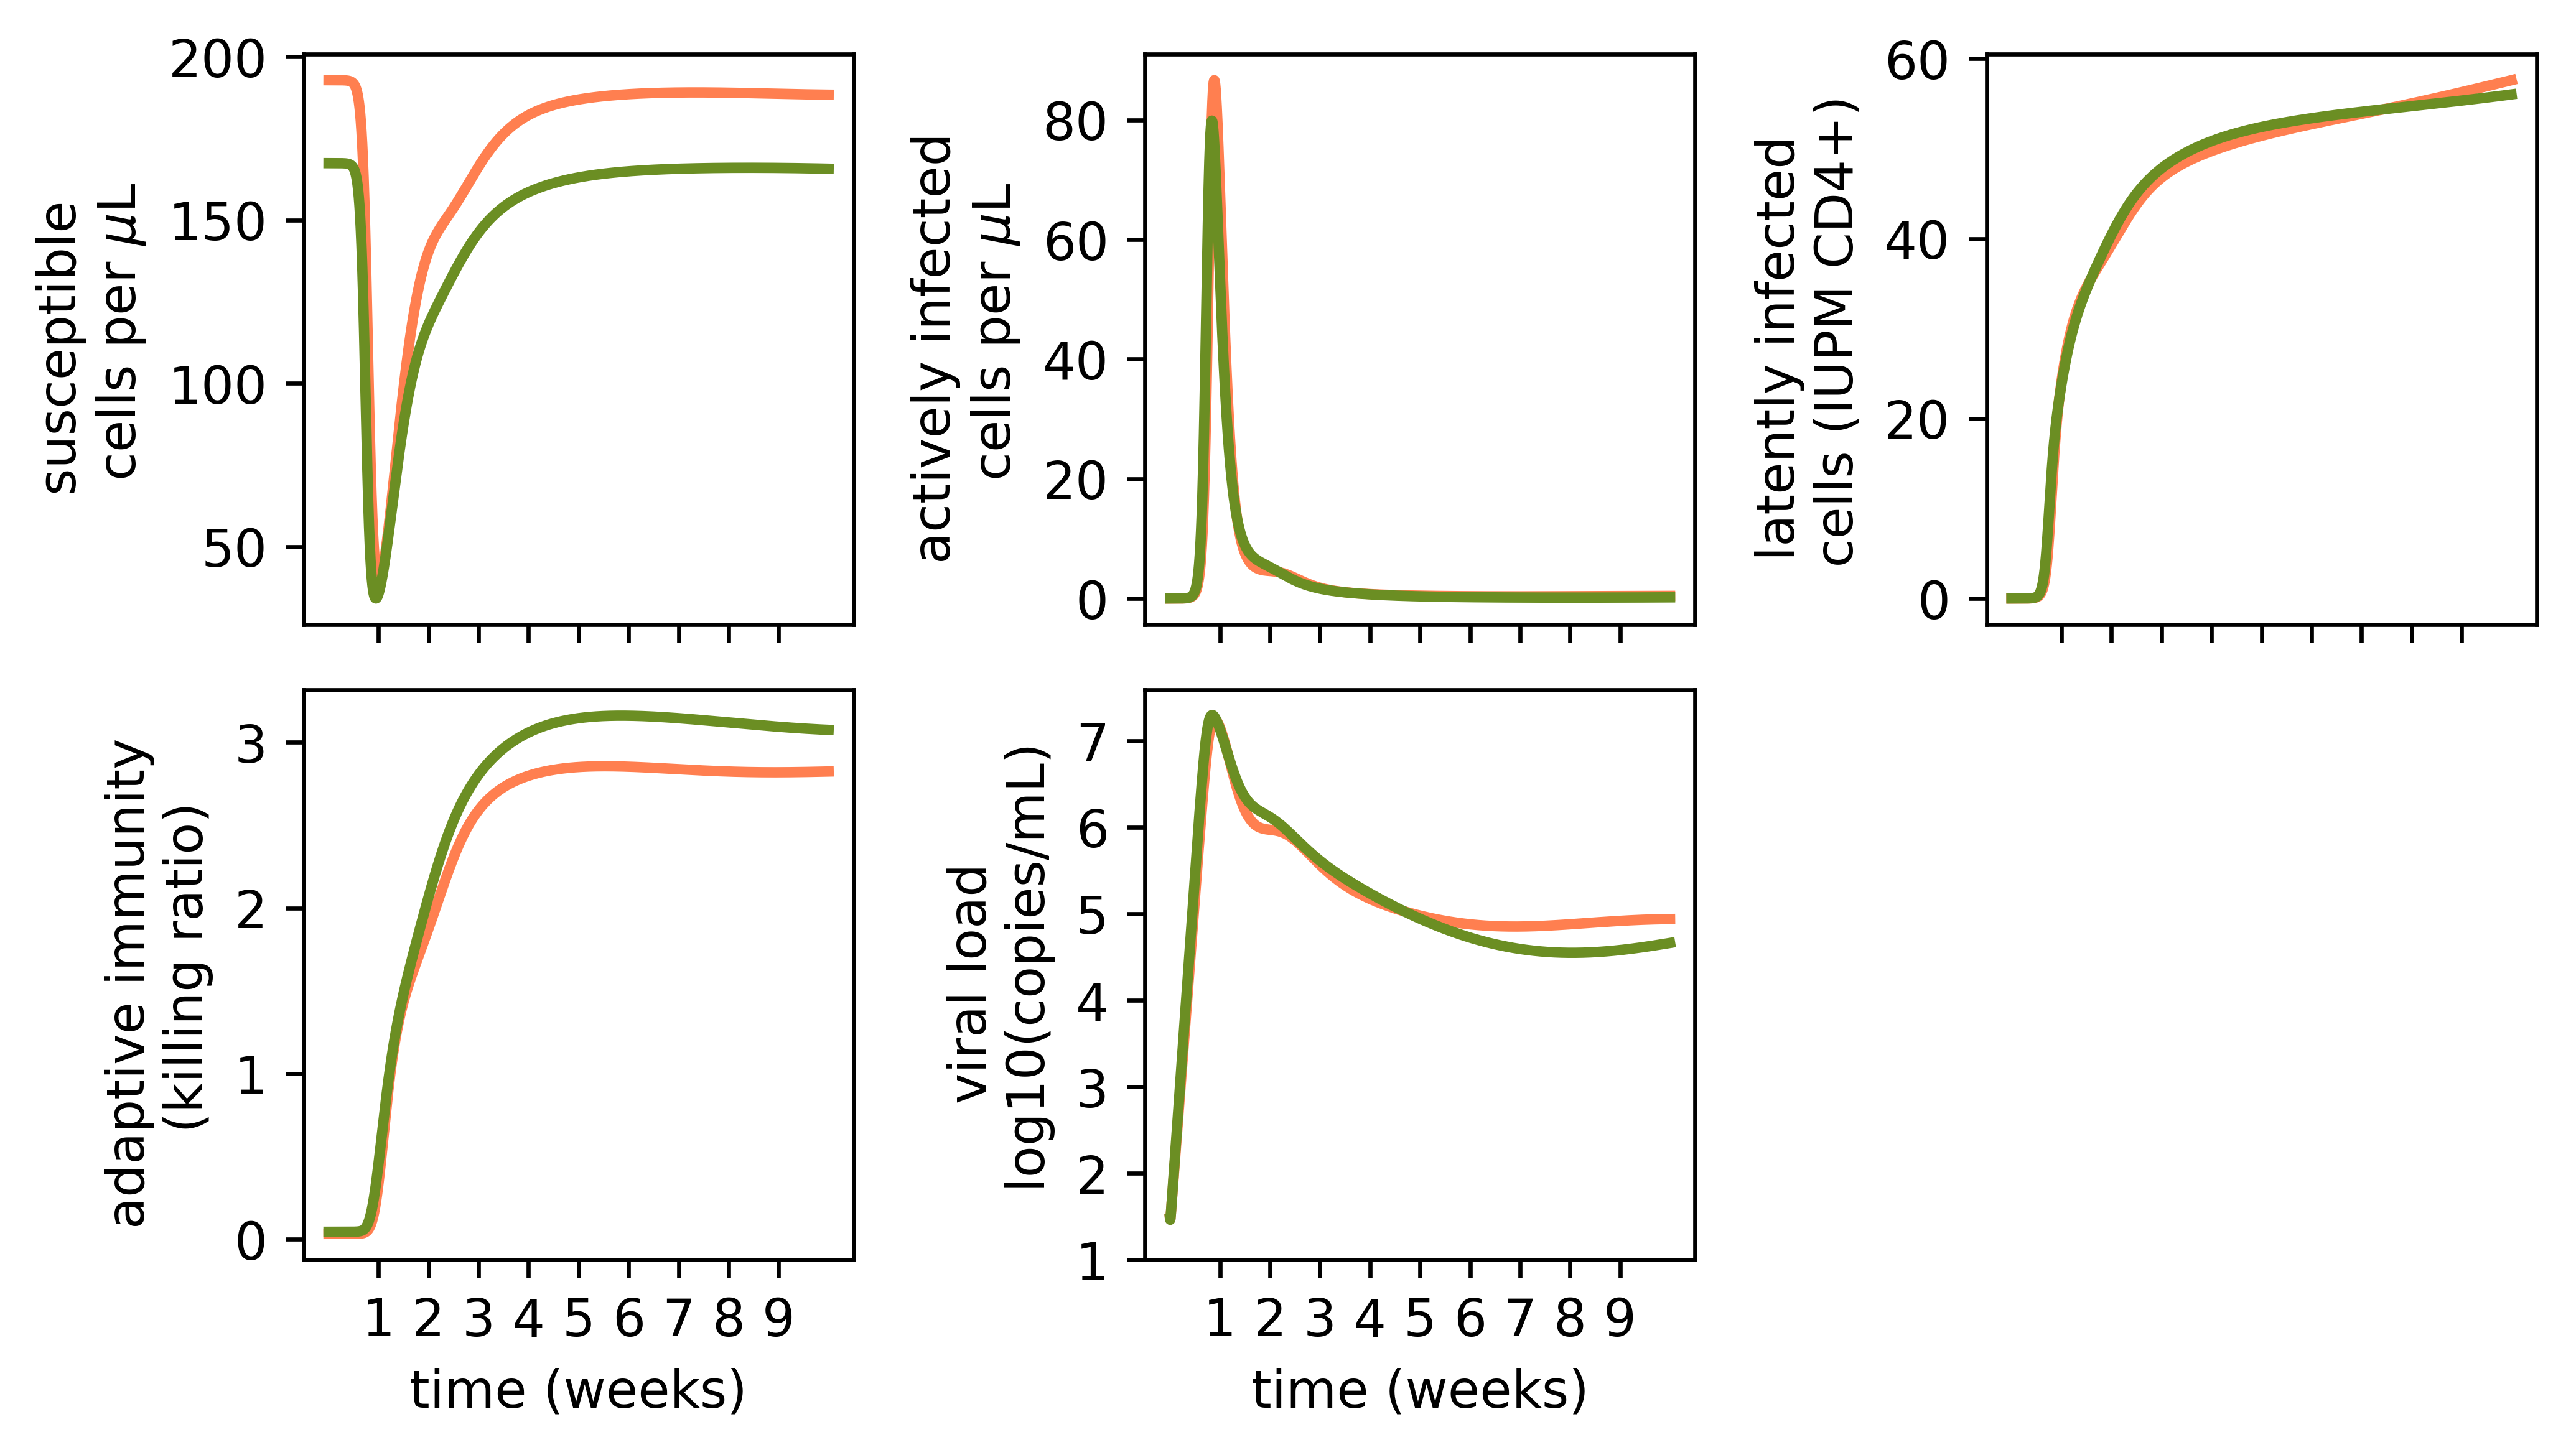

In [16]:
# fixed parameters for viral dynamics model
aS  = 70;       # constant growth rate of susceptibles [cells/uL/day]
Bt0 = 1e-4      # infection rate of T-cells [uL/cells-day]
dI  = 1.0       # infected cell death rate [1/day]
p   = 5e4       # burst rate of virus from cells [virions/cell]
g   = 23        # virus clearance rate [1/day]
lam = 1e-4      # latency probability []
xi  = 1e-5;     # latent activation rate [1/day]
thL = 5.2e-4    # latent clearance rate [1/day]
k   = 0.5;      # immune cell killing rate [uL/cell-day]
aE  = 1e-4;     # immune cell addition [cells/uL-day]

dS=0.4
tau=0.08


plt.figure(figsize=(7,4),dpi=rez)
for i in range(2):
    if i==0:
        dS,tau,k,dE,E50,w=thaipm
        col='coral'
    else:
        dS,tau,k,dE,E50,w=africapm
        col='olivedrab'
        
    R0=aS*Bt0*tau*(1-lam)*p/g/dS/dI; print('R0= ',R0) # basic reproductive number after first positive

    S0=aS/dS; #assumes no real T cell depletion in very early infection
    V0=0.03; #viral load at 30 copies/mL detection limit
    I0=V0*g/p #assumes at equilibrium
    AU0=tau*(1-lam)*I0; AP0=(1-tau)*(1-lam)*I0; LU0=tau*lam*I0; LP0=(1-tau)*lam*I0; #assumes proportions are ok
    E0=aE/dE #assumes no real immune response before first positive?

    X0=np.array([S0,AU0,AP0,LU0,LP0,E0,V0])

    t=np.linspace(0,10*7,1e4) #25 weeks

    sol,vll,infpoz,t_fp,t_max=run_model(t,X0,aS,dS,Bt0,tau,lam,dI,thL,xi,k,aE,dE,E50,w,p,g) 

    plt.subplot(231)
    plt.plot(t/7,sol[:,0],color=col,lw=2)
    plt.ylabel('susceptible \n cells per $\mu$L')

    plt.subplot(232)
    plt.plot(t/7,sol[:,2]+sol[:,1],color=col,lw=2)
    plt.ylabel('actively infected \n cells per $\mu$L')

    plt.subplot(233)
    plt.plot(t/7,(sol[:,3]+sol[:,4])*1000,color=col,lw=2) #divide by 1000 CD4+ T cells and then multiply by 1 million
    plt.ylabel('latently infected \n cells (IUPM CD4+)')

    plt.subplot(234)
    Et=sol[:,5]
    plt.plot(t/7,Et*k/dI,color=col,lw=2)
    plt.ylabel('adaptive immunity \n (killing ratio)')

    plt.subplot(235)
    plt.plot(t/7,vll,color=col,lw=2)
    plt.ylabel('viral load \n log10(copies/mL)')
    plt.yticks(range(1,8,1))

for i in range(5):
    plt.subplot(231+i)
    if i>2:
        plt.xlabel('time (weeks)')
        plt.xticks(range(1,10,1))
    else:
        plt.xticks(range(1,10,1),[])
        
plt.tight_layout()
plt.savefig('figures/det_model-means.pdf')


In [17]:
thaipm

[0.36295299179106444,
 0.093504644816617966,
 1.9791677764202271,
 0.0063639114955897557,
 191.91657252019164,
 3.0068655393621624]

In [18]:
africapm

[0.41804172285039554,
 0.11423005510464797,
 1.506186118856198,
 0.003404636682010092,
 220.96648113604721,
 3.3018818032762169]

In [19]:
day7TS = [1.4771573604060908, 1.7208121827411174, 2.126903553299491, 3.2233502538071024, 3.7512690355329923, 
          4.1573604060913665, 4.1573604060913665, 3.913705583756345, 5.213197969543145, 4.11675126903553, 
          2.126903553299491, 2.5329949238578653, 2.0050761421319807, 1.1522842639593907, 0.9492385786802013, 
          1.7208121827411174, 1.8832487309644645, 4.563451776649745, 6.309644670050758] + [-1]*15

day7Periph = [3.2363451776649717, 3.9380710659898455, 1.657461928934009, 2.0668020304568504, 
              2.4761421319796915, 4.05502538071066, 5.926294416243654, 2.9439593908629407, 
              2.8270050761421306, 2.0668020304568504, 0.19553299492385556, 0.07857868020304593, 
              1.0142131979695432, 1.657461928934009, 3.41177664974619, 3.1193908629441625, 
              2.417664974619289, 2.8854822335025383, 3.2363451776649717, 1.9498477157360408, 
              1.1311675126903529, 1.482030456852792, 1.657461928934009, 2.534619289340099, 
              3.29482233502538, 4.522842639593908, 1.5405076142131944, 1.0726903553299456, 
              0.6048730964466971, 1.3650761421319775, 3.704162436548221, 3.9380710659898455, 
              3.704162436548221, 3.29482233502538, 1.5989847715736016] + [-1]*15

day10TS=[ 8.999691149502937, 7.83223627063024, 6.256172184152106, 5.114815172280672, 
        5.98747225171315, 5.98160409226908, 6.004767879548304, 6.5503522825981975, 
        8.184789113019974, 4.784808416176041, 4.084335488852425, 2.6977511823183065, 
        4.241540391854066, 4.008049416079523, 4.159695010134158, 2.452215037158574, 
        2.1019785734967655, 2.4783129041598286, 2.066769616832346, 1.310858025287132]

day10Periph = [6.532130103271889, 6.298639127497346, 5.9425345043914675, 7.422082810539521, 
               5.796448219283853, 5.262291284625036, 6.461712189943057, 5.63569153556606, 
               5.343827815847888, 3.9135411639803124, 3.904738924814204, 2.6847794614419414, 
               3.230363864491835, 5.267541743074986, 5.620712286458833, 5.638007914293986, 
               5.354946433741915, 4.537728018531027, 5.491921629186365, 5.2000579094681925, 
               6.078583148344755, 5.576392240131256, 4.283389634205186, 3.941955409709486, 
               4.3678602451500765, 4.60135122092462, 6.41090628317729, 6.14514043046038, 
               5.7949039667985645, 5.444667503136756, 6.463102017179807, 5.7626290898561905, 
               5.409458546472344, 5.733288292635841, 6.842370427564909, 2.9839011678409335, 
               6.859666055400055, 6.859666055400055, 4.869124601872407, 6.620306920181449, 
               6.590966122961106, 5.414709004922301, 5.064472541260493, 7.247427854454202, 
               5.671363767976061, 5.146009072483345, 6.161509506804364, 5.986391274973464, 
               5.691593475533246, 2.965370138017562, 2.8515587298523286, 1.8650902422546025, 
               3.289199884181059, 3.6394363478428673, 4.5208956664414615, 4.196757069780908, 
               3.782279702731394, 3.315297751182314, 4.616793745777436, 4.208184538171992, 
               2.982356915355659, 2.4217932631985306, 2.1269954637583197, 1.6600135122092397, 
               2.7922594344175238, 1.7969887076537034, 1.446752243991888, 2.643239069587871, 
               1.9368979828201844, 1.6421001833799806]


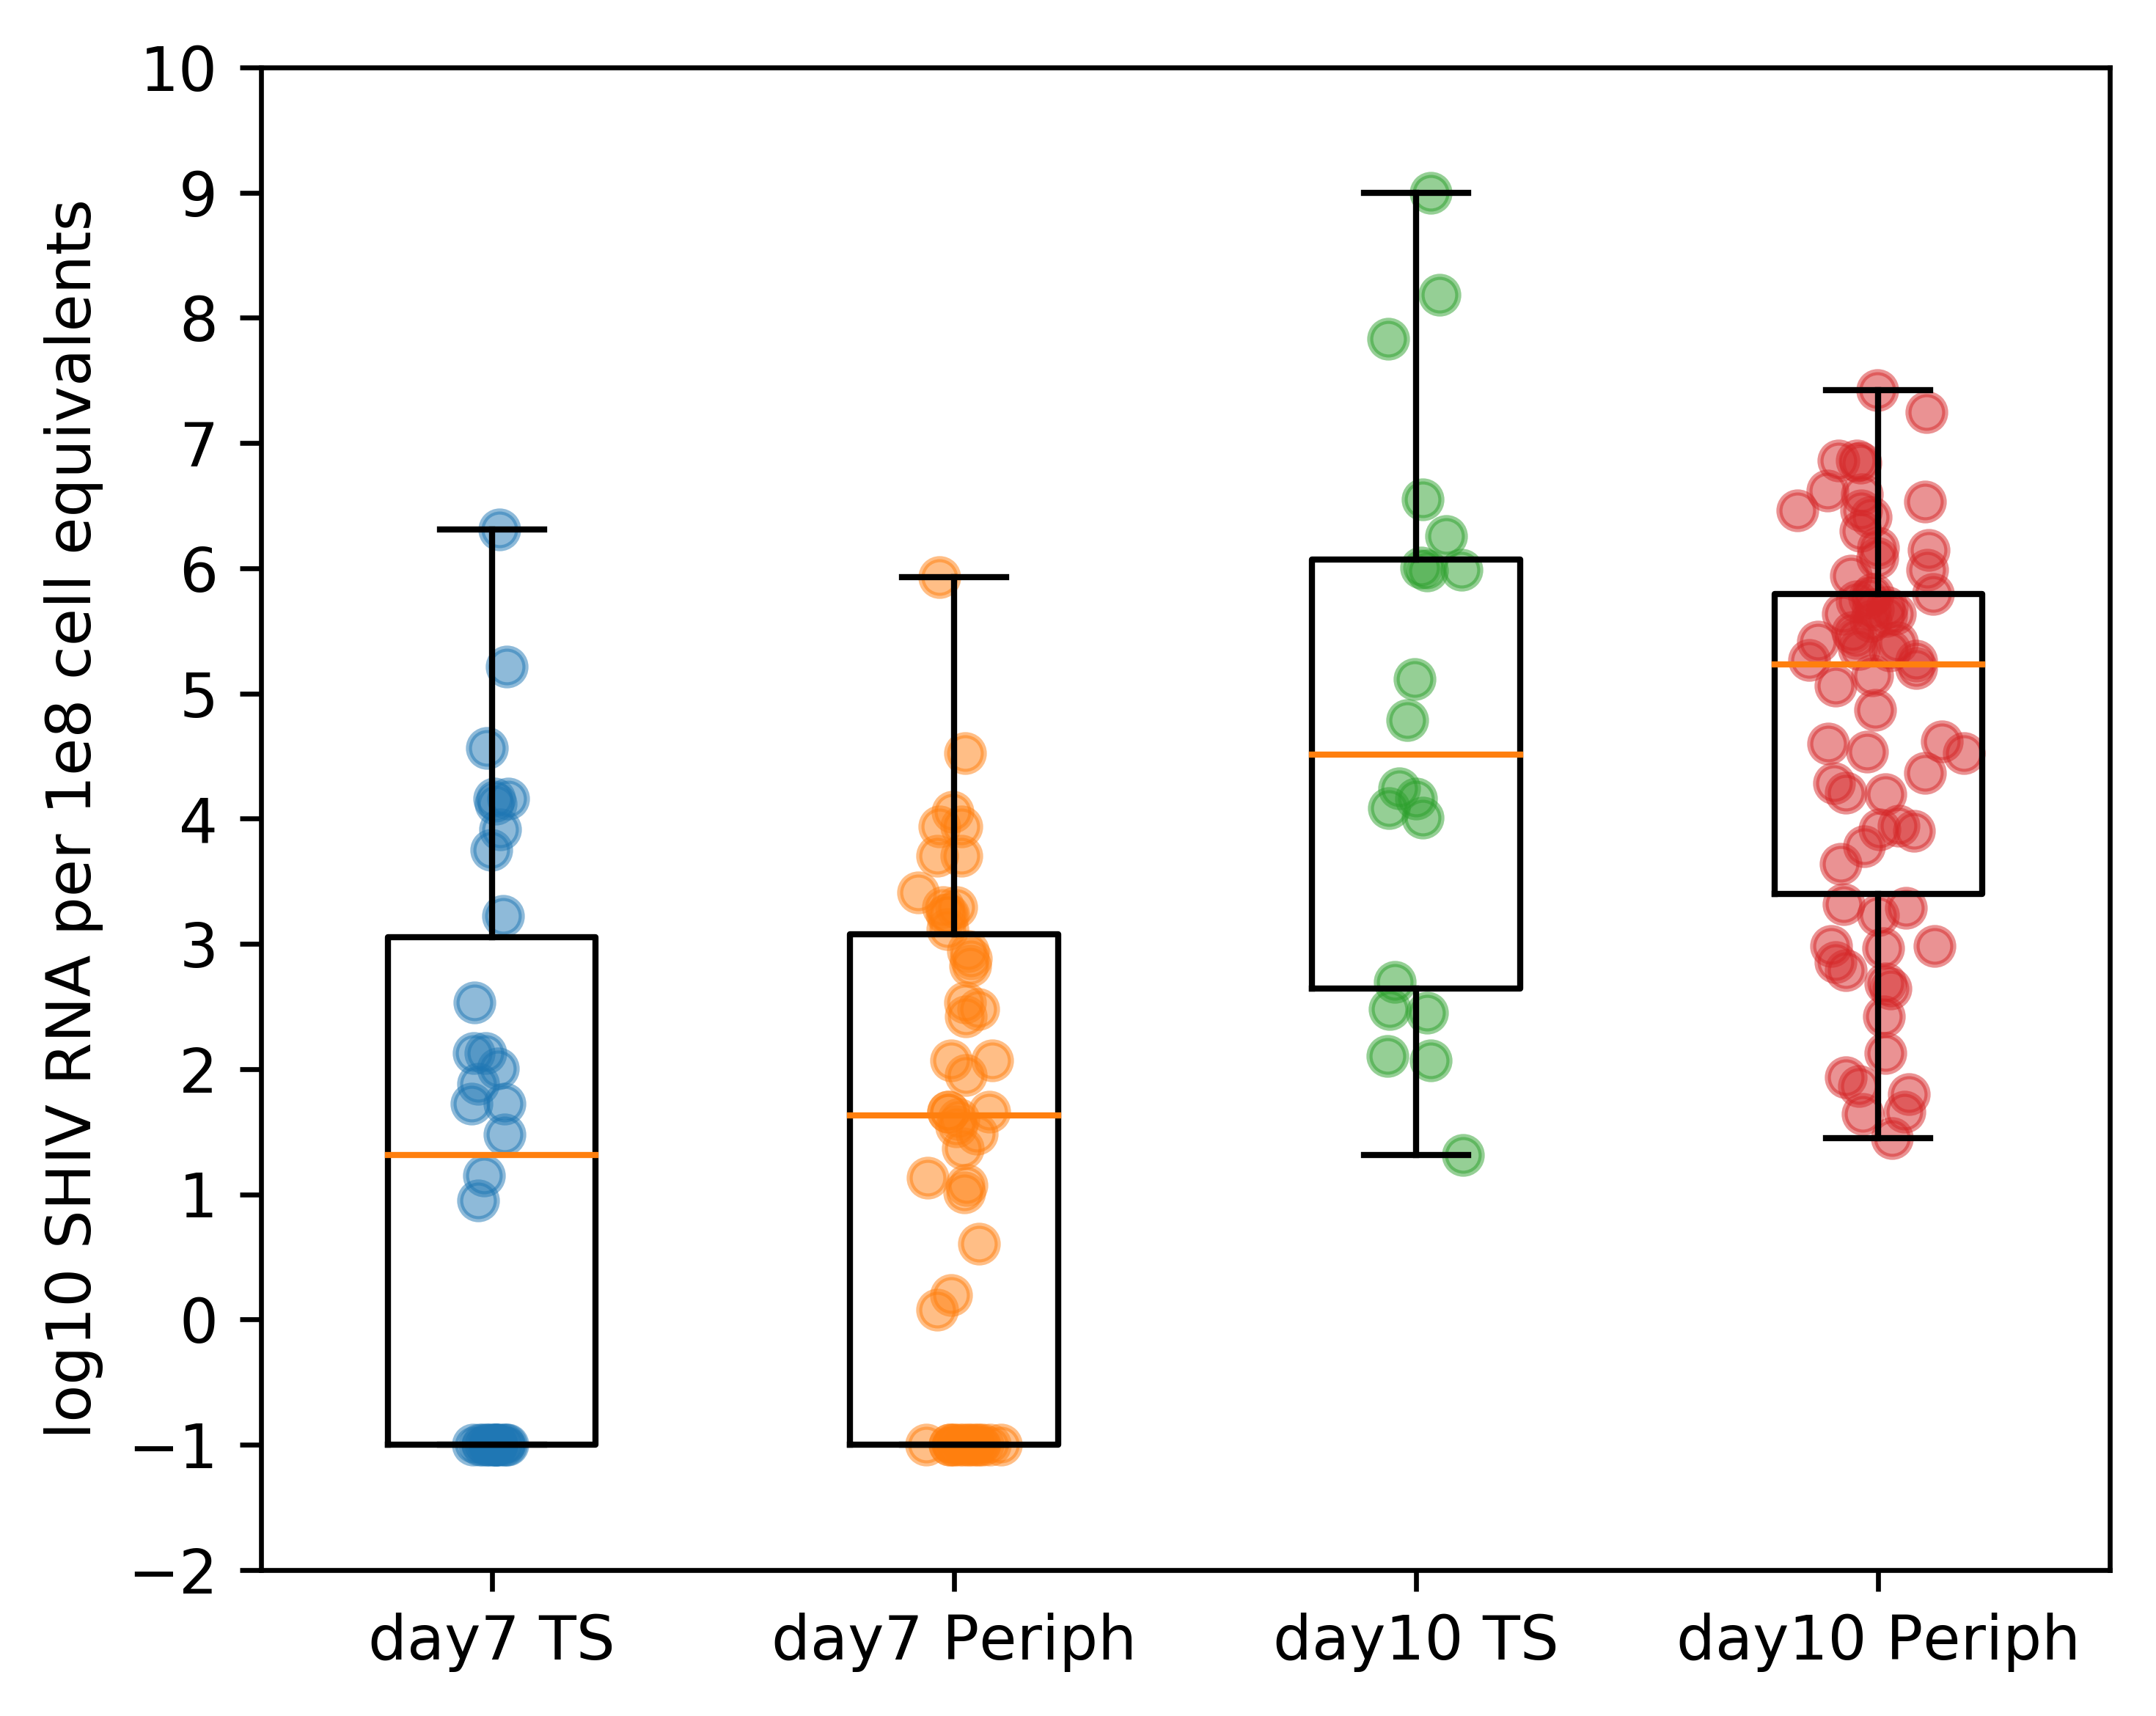

In [20]:
plt.figure(figsize=(5,4),dpi=rez)

Liu=[day7TS,day7Periph,day10TS,day10Periph]
plt.boxplot(Liu)
xLiu=[1,2,3,4]
plt.xticks(xLiu,['day7 TS','day7 Periph','day10 TS','day10 Periph'])
plt.ylabel('log10 SHIV RNA per 1e8 cell equivalents')
for i in range(4):
    plt.scatter(np.random.normal(1,0.02,len(Liu[i]))*xLiu[i],Liu[i],alpha=0.5)
plt.yticks(range(-2,11))
plt.tight_layout()
plt.savefig('figures/jinyanLIU.pdf')


In [27]:
#rough R0 calculation:
dT=3*0.8 #3 days times infected cell death rate

print(np.log(10**np.median(day10TS)/10**np.median(day7TS))/dT+1)

print(np.log(10**np.median(day10Periph)/10**np.median(day7Periph))/dT+1)



4.06862981716
4.45670909652
